# TurbSim and FAST.Farm Workflow
Regis Thedin


In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os, glob, sys
import subprocess
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt

#from stochasticTurbulenceTools_regis import stochasticTurbulence
from pyFAST.input_output import FASTInputFile, TurbSimFile, VTKFile
from pyFAST.fastfarm import writeFastFarm, fastFarmTurbSimExtent, plotFastFarmSetup
from pyFAST.fastfarm.TurbSimCaseCreation import TSCaseCreation, writeTimeSeriesFile

def cosd(t): return np.cos(np.deg2rad(t))
def sind(t): return np.sin(np.deg2rad(t))

## User-modifiable: Set desired turbine locations and sweep of parameters

Notes on some values to be set

- `fmax`: \
    The max rotor speed is 7.56 rpm, or, 0.126 rot per s \
    For six times per revolutions (6P), $0.126*6 = 0.756 s^{-1}$ \
    For ten times per revolutions (10P), $0.126*10 = 1.26 s^{-1}$ \
    For 12 times per revolutions (12P), $0.126*12 = 1.512 s^{-1}$ \
    The `DT_High` would then be computed using that value, so `DT_High = 1/2f`is 0.66 s for 6P, 0.397 s for 10P, and 0.331 for 12P.
    Therefore I can try to have about 0.3 s time step for the High box. I will modify `fmax` to be such that `DT_High = 0.3 = 1/(2f)` so `fmax=1.666=10/6` 

In [2]:
# ******************************************** USER INPUT ******************************************** #
# Wind turbines properties wrt current mesh (0-indexed)
D    = 250  # IEA 15 MW (246 m exactly)
zhub = 150  # IEA 15 MW (148.84 m exactly)
wts  = {  # Original 12-turbine farm
          0 :{'x':0.0,     'y':0,       'z':0.0,  'D':D,  'zhub':zhub},
          1 :{'x':1852.0,  'y':0,       'z':0.0,  'D':D,  'zhub':zhub},
          2 :{'x':3704.0,  'y':0,       'z':0.0,  'D':D,  'zhub':zhub},
          3 :{'x':5556.0,  'y':0,       'z':0.0,  'D':D,  'zhub':zhub},
          4 :{'x':7408.0,  'y':0,       'z':0.0,  'D':D,  'zhub':zhub},
          5 :{'x':1852.0,  'y':1852.0,  'z':0.0,  'D':D,  'zhub':zhub},
          6 :{'x':3704.0,  'y':1852.0,  'z':0.0,  'D':D,  'zhub':zhub},
          7 :{'x':5556.0,  'y':1852.0,  'z':0.0,  'D':D,  'zhub':zhub},
          8 :{'x':7408.0,  'y':1852.0,  'z':0.0,  'D':D,  'zhub':zhub},
          9 :{'x':3704.0,  'y':3704.0,  'z':0.0,  'D':D,  'zhub':zhub},
          10:{'x':5556.0,  'y':3704.0,  'z':0.0,  'D':D,  'zhub':zhub},
          11:{'x':7408.0,  'y':3704.0,  'z':0.0,  'D':D,  'zhub':zhub},
        }
refTurb_rot = 0

# TurbSim variables
nSeeds = 6

# General hard-coded parameters
cmax     = 5    # maximum blade chord (m). Turbine specific. 5.77 m for IEA 15 MW
fmax     = 5.0  # maximum excitation frequency (Hz). Turbine specific, 5Hz is satisfactory for modern multi-MW turbine.
Cmeander = 1.9  # Meandering constant (-)

# Default aerodynamic and elastic modules (full ElastoDyn and AeroDyn)
            #  T1      T2      T3      T4      T5      T6      T7      T8      T9      T10     T11     T12
ADmodel = [ ['ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn'] ]
EDmodel = [ ['FED',  'FED',  'FED',  'FED',  'FED',  'FED',  'FED',  'FED',  'FED',  'FED',  'FED',  'FED' ] ]
# Default yaw array (all zero)
            #  T1      T2      T3      T4      T5      T6      T7      T8      T9      T10     T11     T12
yaw = [     [   0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0]  ]


# ----------- SOWFA boxes parameters ---------------
# High-res boxes settings. Extents are given from the turbine location (for high, total width = extent_high)
dt_high_sowfa = 0.6                # sampling frequency of high-res files
ds_high_sowfa = 10.0               # dx, dy, dz that you want these high-res files at
extent_high   = 1.2                # high-res box extent in y and x for each turbine, in D. This is the total extent: half to each side.
# Low-res boxes settings (if the turbine layout is odd, manual tweaks to the extent are needed)
dt_low_sowfa  = 3                  # sampling frequency of low-res files (must be a multiple of dt_high)
ds_low_sowfa  = 20.0               # dx, dy, dz of low-res files
extent_low    = [8, 12, 8, 8, 2]   #  13x9x1 km domain
extent_low    = [3, 8,  3, 3, 2]   #  new for turbsim low. using Y0_Low <= WT_Y_min -3D. xmin/xmax not needed for this.
                                   # 3 is what KS had hardcoded at some point; 8 is per python-toolbox/pyFAST/fastfarm:fastFarmBoxExtent default's
ds_low_desired = ds_low_sowfa
# **************************************************************************************************** #

### Shell work

In [4]:
## For Shell work (comment out/in)
path = '/projects/shellwind/rthedin/task_shell_TSinflow_8.6'

# TurbSim variables
tmax   = 1800

# General hard-coded parameters
# Running this case with lower temporal resolution (0.3 s)
fmax     = 10/6  # maximum excitation frequency (Hz), will dictate the DT_High and DT_Low
zbot     = 1.0  # vertical start of the turbulence box (m). Depend on hub height and expected vertical meandering of wakes.
ds_low_desired = 25     # desired ds_low given ranges of conditions simulated. We want to keep the ds the same between them
#dt_low_desired  = 3     # desired dt_low for fast farm. The low turbsim box will be run at dt_high (=1/(2*fmax)). Should be a multiple of dt_high

# Create desired sweep of parameters for atmospheric conditions
vhub       = [8.6]
shear      = [0.2]
TIclass    = ['A']           # arbitrary
TIvalue    = [10]

# Create desired sweep of parameters for different cases within an atmospheric condition
inflow_deg = np.arange(-20,20.1,2)

# Set the yaw of each turbine for wind dir. One row for each wind direction. If a sweep of initial yaw for each
# wind direction is desired, then repeat the inflow_deg array and create the extra rows in yaw_init accordingly
yaw_init = [ #  T1      T2      T3      T4      T5      T6      T7      T8      T9      T10     T11     T12
            [  -20,    -20,    -20,    -20,    -20,    -20,    -20,    -20,    -20,    -20,    -20,     -20], # -20 wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], # -18 wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], # -16 wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], # -14 wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], # -12 wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], # -10 wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], # -8  wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], # -6  wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], # -4  wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], # -2  wind dir
            [ 20.3125, 20.3125, 15.625, 10.9375, 0,   15.625,  17.1875, 10.9375, 0,   15.625,  14.0625,   0], #  0  wind dir. From Raf
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], #  2  wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], #  4  wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], #  6  wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], #  8  wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], #  10 wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], #  12 wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], #  14 wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], #  16 wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], #  18 wind dir
            [   20,     20,     20,     20,     20,     20,     20,     20,     20,     20,     20,      20], #  20 wind dir
           ]

sweepWakeSteering    = True
sweepYawMisalignment = False

# Site parameters
latitude_mayflower = 40.761
latitude = latitude_mayflower

In [3]:
## For Shell work (comment out/in)
path = '/projects/shellwind/rthedin/task_shell_TSinflow_8.6_smallDomain0degOnly'

# TurbSim variables
tmax   = 1800

# General hard-coded parameters
# Running this case with lower temporal resolution (0.3 s)
fmax     = 10/6  # maximum excitation frequency (Hz), will dictate the DT_High and DT_Low
zbot     = 1.0  # vertical start of the turbulence box (m). Depend on hub height and expected vertical meandering of wakes.
ds_low_desired = 25     # desired ds_low given ranges of conditions simulated. We want to keep the ds the same between them
#dt_low_desired  = 3     # desired dt_low for fast farm. The low turbsim box will be run at dt_high (=1/(2*fmax)). Should be a multiple of dt_high

# Create desired sweep of parameters for atmospheric conditions
vhub       = [8.6]
shear      = [0.2]
TIclass    = ['A']           # arbitrary
TIvalue    = [10]

# Create desired sweep of parameters for different cases within an atmospheric condition
inflow_deg = [0]

# Set the yaw of each turbine for wind dir. One row for each wind direction. If a sweep of initial yaw for each
# wind direction is desired, then repeat the inflow_deg array and create the extra rows in yaw_init accordingly
yaw_init = [ #  T1      T2      T3      T4      T5      T6      T7      T8      T9      T10     T11     T12
            [ 20.3125, 20.3125, 15.625, 10.9375, 0,   15.625,  17.1875, 10.9375, 0,   15.625,  14.0625,   0], #  0  wind dir. From Raf
           ]

sweepWakeSteering    = False
sweepYawMisalignment = False

# Site parameters
latitude_mayflower = 40.761
latitude = latitude_mayflower

In [4]:
## For Shell work (comment out/in)
path = '/projects/shellwind/rthedin/task_shell_TSinflow_10.6'

# TurbSim variables
tmax   = 1800

# General hard-coded parameters
# Running this case with lower temporal resolution (0.3 s)
fmax     = 10/6  # maximum excitation frequency (Hz), will dictate the DT_High and DT_Low
zbot     = 1.0  # vertical start of the turbulence box (m). Depend on hub height and expected vertical meandering of wakes.
ds_low_desired = 25     # desired ds_low given ranges of conditions simulated. We want to keep the ds the same between them
#dt_low_desired  = 3     # desired dt_low for fast farm. The low turbsim box will be run at dt_high (=1/(2*fmax)). Should be a multiple of dt_high

# Create desired sweep of parameters for atmospheric conditions
vhub       = [10.6]
shear      = [0.2]
TIclass    = ['A']           # arbitrary
TIvalue    = [10]

# Create desired sweep of parameters for different cases within an atmospheric condition
inflow_deg = np.arange(-20,20.1,2)

# Set the yaw of each turbine for wind dir. One row for each wind direction. If a sweep of initial yaw for each
# wind direction is desired, then repeat the inflow_deg array and create the extra rows in yaw_init accordingly
yaw_init = [ #  T1      T2      T3      T4      T5      T6      T7      T8      T9      T10     T11     T12
            [  -20,    -20,    -20,    -20,    -20,    -20,    -20,    -20,    -20,    -20,    -20,     -20], # -20 wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], # -18 wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], # -16 wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], # -14 wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], # -12 wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], # -10 wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], # -8  wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], # -6  wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], # -4  wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], # -2  wind dir
            [ 18.75,   20.3125, 15.625, 10.9375, 0,   15.625,  17.1875, 10.9375, 0,   15.625,  12.5,      0], #  0  wind dir. From Raf
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], #  2  wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], #  4  wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], #  6  wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], #  8  wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], #  10 wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], #  12 wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], #  14 wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], #  16 wind dir
            [    0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,       0], #  18 wind dir
            [   20,     20,     20,     20,     20,     20,     20,     20,     20,     20,     20,      20], #  20 wind dir
           ]

sweepWakeSteering    = True
sweepYawMisalignment = False

# Site parameters
latitude_mayflower = 40.761
latitude = latitude_mayflower

In [3]:
## For Shell work (comment out/in)
path = '/projects/shellwind/rthedin/task_shell_TSinflow_10.6_smallDomain0degOnly'

# TurbSim variables
tmax   = 1800

# General hard-coded parameters
# Running this case with lower temporal resolution (0.3 s)
fmax     = 10/6  # maximum excitation frequency (Hz), will dictate the DT_High and DT_Low
zbot     = 1.0  # vertical start of the turbulence box (m). Depend on hub height and expected vertical meandering of wakes.
ds_low_desired = 25     # desired ds_low given ranges of conditions simulated. We want to keep the ds the same between them
#dt_low_desired  = 3     # desired dt_low for fast farm. The low turbsim box will be run at dt_high (=1/(2*fmax)). Should be a multiple of dt_high

# Create desired sweep of parameters for atmospheric conditions
vhub       = [10.6]
shear      = [0.2]
TIclass    = ['A']           # arbitrary
TIvalue    = [10]

# Create desired sweep of parameters for different cases within an atmospheric condition
inflow_deg = [0]

# Set the yaw of each turbine for wind dir. One row for each wind direction. If a sweep of initial yaw for each
# wind direction is desired, then repeat the inflow_deg array and create the extra rows in yaw_init accordingly
yaw_init = [ #  T1      T2      T3      T4      T5      T6      T7      T8      T9      T10     T11     T12
            [ 18.75,   20.3125, 15.625, 10.9375, 0,   15.625,  17.1875, 10.9375, 0,   15.625,  12.5,      0], #  0  wind dir. From Raf
           ]

sweepWakeSteering    = False
sweepYawMisalignment = False

# Site parameters
latitude_mayflower = 40.761
latitude = latitude_mayflower

### Equinor work

In [3]:
## For Equinor work (comment out/in)
path = '/projects/shellwind/rthedin/task_equinor'

# TurbSim variables
tmax   = 1800

# General hard-coded parameters
# Running this case with lower temporal resolution (0.3 s)
fmax            = 10/6  # maximum excitation frequency (Hz), will dictate the DT_High and DT_Low for TurbSim boxes
zbot            = 1.0 #0.01  # vertical start of the turbulence box (m). Depend on hub height and expected vertical meandering of wakes.
ds_low_desired  = 25.0    # desired ds_low given ranges of conditions simulated. We want to keep the ds the same between them
#dt_low_desired  = 5.  # good for 8.6, not 10.6. used to have 3     # desired dt_low for fast farm. The low turbsim box will be run at dt_high (=1/(2*fmax)). Should be a multiple of dt_high

# Create desired sweep of parameters for atmospheric conditions
vhub       = [8.6, 10.6, 12.6] # pick just one, the lowest of 8.6
shear      = [0.2]
TIclass    = ['A']           # arbitrary
TIvalue    = [10]

# Create desired sweep of parameters for different cases within an atmospheric condition
inflow_deg = [0]       
yaw_init = np.repeat(yaw, len(inflow_deg), axis=0)

sweepWakeSteering    = False
sweepYawMisalignment = False

# Specific models to use for aerodynamics and elastic moduled. Should be specified in a dictionary form,
# similar to the turbines. Should be of the same length as the turbines and each column represents a
# different scenario to be executed. The number of cases will be multiplied by the sweep of these parameters.
# The columns related to each case in these ditionaries go together; eg: case 1 is first column of both
# The following cases are considered:
# Case 1: no simplified models, all turbines have full ED, and AeroDyn 
# Cases 2, 4, 6: number of simplified turbines: 3, 6, 9. SED and AeroDyn on the simplified ones
# Cases 3, 5, 7: number of simplified turbines: 3, 6, 9. SED and AeroDisk on the simplified ones
ADmodel = [ #  T1      T2      T3      T4      T5      T6      T7      T8      T9      T10     T11     T12
            ['ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn'], # Case 1
            ['ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn'], # Case 2
            ['ADsk', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADsk', 'ADyn', 'ADyn', 'ADyn', 'ADsk', 'ADyn', 'ADyn'], # Case 3
            ['ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn'], # Case 4
            ['ADsk', 'ADsk', 'ADyn', 'ADyn', 'ADyn', 'ADsk', 'ADsk', 'ADyn', 'ADyn', 'ADsk', 'ADsk', 'ADyn'], # Case 5
            ['ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn', 'ADyn'], # Case 6
            ['ADsk', 'ADsk', 'ADsk', 'ADyn', 'ADyn', 'ADsk', 'ADsk', 'ADsk', 'ADyn', 'ADsk', 'ADsk', 'ADsk'], # Case 7
          ]

EDmodel = [ #  T1      T2      T3      T4      T5      T6      T7      T8      T9      T10     T11     T12
            ['FED',  'FED',  'FED',  'FED',  'FED',  'FED',  'FED',  'FED',  'FED',  'FED',  'FED',  'FED' ], # Case 1
            ['SED',  'FED',  'FED',  'FED',  'FED',  'SED',  'FED',  'FED',  'FED',  'SED',  'FED',  'FED' ], # Case 2
            ['SED',  'FED',  'FED',  'FED',  'FED',  'SED',  'FED',  'FED',  'FED',  'SED',  'FED',  'FED' ], # Case 3
            ['SED',  'SED',  'FED',  'FED',  'FED',  'SED',  'SED',  'FED',  'FED',  'SED',  'SED',  'FED' ], # Case 4
            ['SED',  'SED',  'FED',  'FED',  'FED',  'SED',  'SED',  'FED',  'FED',  'SED',  'SED',  'FED' ], # Case 5
            ['SED',  'SED',  'SED',  'FED',  'FED',  'SED',  'SED',  'SED',  'FED',  'SED',  'SED',  'SED' ], # Case 6
            ['SED',  'SED',  'SED',  'FED',  'FED',  'SED',  'SED',  'SED',  'FED',  'SED',  'SED',  'SED' ], # Case 7
          ]

# Site parameters
latitude_equinor = 45
latitude = latitude_equinor

## End of user-modifiable section
---

## Create auxiliary arrays that fully define the case

In [4]:
# Auxiliary variables and some checks
seedValues = [2318573, 122299, 123456, 389432, -432443, 9849898]

In [5]:
# Create case path is doesn't exist
if not os.path.exists(path):
    os.makedirs(path)
    
# Perform some checks
if np.shape(TIclass) != np.shape(TIvalue):
    raise ValueError(f'The array TI class should correspond to TIvalue and thus have the same length')
    
if len(seedValues) != nSeeds:
    raise ValueError(f'Number of seeds is {nSeeds} but {len(seedValues)} seed values were given. Adjust the seedValues array accordingly')
    
if not (np.array(extent_low)>=0).all():
    raise ValueError(f'The array for low-res box extents should be given with positive values')

if dt_low_sowfa < dt_high_sowfa:
    raise ValueError(f'The temporal resolution dT_High should not be greater than dT_Low on the SOWFA side')

if ds_low_sowfa < ds_high_sowfa:
    raise ValueError(f'The grid resolution dS_High should not be greater than dS_Low on the SOWFA side')

assert isinstance(extent_high, (float,int))
if extent_high<=0:
    raise ValueError(f'The extent of high boxes should be positive')
    
#assert dt_low_desired%(1/(2*fmax)) < 1e-10


if np.shape(ADmodel) != np.shape(EDmodel):
    raise ValueError('Every case should have the aerodynamic and elastic model selected. The number of cases (lines) in `ADmodel` and `EDmodel` should be the same')
    
if len(wts) != np.shape(ADmodel)[1]:
    raise ValueError(f'The number of turbines in wts ({len(wts)}) should match the number of turbines in the ADmodel and EDmodel arrays ({np.shape(ADmodel)[1]})')
    
if len(inflow_deg) != len(yaw_init):
    raise ValueError(f'One row for each inflow angle should be given in yaw_init. Currently {len(inflow_ang)} inflow angles and {len(yaw_init)} yaw entries')
    
# check if all entries are either FED, SED
# check if all entries are either ADyn, ADsk

### Set values for pitch and rotor speed given wind speed

In [6]:
# Values from BinVals.csv. Starting values for ElastoDyn, ServoDyn, and HydroDyn depending on the windspeed. Hardcoded.
bins = xr.Dataset({'WaveHs':      (['wspd'], [1.172, 1.323, 1.523, 1.764, 2.255]),
                   'WaveTp':      (['wspd'], [7.287, 6.963, 7.115, 6.959, 7.067]),
                   'RotSpeed':    (['wspd'], [4.995, 6.087, 7.557, 7.557, 7.557]),
                   'BlPitch':     (['wspd'], [0.315, 0,     0.645, 7.6,   13.8 ]),
                   #'WvHiCOffD':   (['wspd'], [0,     0,     0,     0,     0    ]), # 2nd order wave info. Unused for now
                   #'WvLowCOffS':  (['wspd'], [0,     0,     0,     0,     0    ]), # 2nd order wave info. Unused for now
                  },  coords={'wspd': [6.6, 8.6, 10.6, 12.6, 'else']} )

### Set hub height for Turbsim given wind speed (not actual hub height)

In [7]:
# convert parameters to list if necessary
vhub       = [vhub      ] if isinstance(vhub      , (int,float)) else vhub      
shear      = [shear     ] if isinstance(shear     , (int,float)) else shear     
TIclass    = [TIclass   ] if isinstance(TIclass   , str)         else TIclass 
TIvalue    = [TIvalue   ] if isinstance(TIvalue   , (int,float)) else TIvalue 
inflow_deg = [inflow_deg] if isinstance(inflow_deg, (int,float)) else inflow_deg

# Aux variables
nTurbines = len(wts)

### Calculate turbine positions given inflow direction and organize information into different data structure

In [8]:
# Calculate the rotated positions of the turbines wrt the reference turbine
wts_rot={}
for inflow in inflow_deg:
    for i , turb in wts.items():
        ref = wts[refTurb_rot]

        xori = wts[i]['x']
        x = ref['x'] + (wts[i]['x']-ref['x'])*cosd(inflow) - (wts[i]['y']-ref['y'])*sind(inflow)
        yori = wts[i]['y']
        y = ref['y'] - (wts[i]['x']-ref['x'])*sind(-inflow) + (wts[i]['y']-ref['y'])*cosd(-inflow)
        z = wts[i]['z']
        D = wts[i]['D']
        zhub = wts[i]['zhub']

        wts_rot[inflow,i] = {'x':x, 'y':y, 'z':z,
                             'D':D, 'zhub':zhub,
                            }
wts_rot_ds = pd.DataFrame.from_dict(wts_rot, orient='index').to_xarray().rename({'level_0':'inflow_deg','level_1':'turbine'})

### Create array for all atmospheric conditions

In [9]:
nConditions = len(vhub) * len(shear) * len(TIvalue)

# Repeat arrays as necessary to build xarray Dataset
vhub_repeat    = np.repeat(vhub,    nConditions/len(vhub),    axis=0)
shear_repeat   = np.repeat(shear,   nConditions/len(shear),   axis=0)
TIclass_repeat = np.repeat(TIclass, nConditions/len(TIclass), axis=0)
TIvalue_repeat = np.repeat(TIvalue, nConditions/len(TIvalue), axis=0)

allCond = xr.Dataset({'vhub':    (['cond'], vhub_repeat   ),
                      'shear':   (['cond'], shear_repeat  ),
                      'TIclass': (['cond'], TIclass_repeat),
                      'TIvalue': (['cond'], TIvalue_repeat)},
                      coords={'cond': np.arange(nConditions)} )

### Create array for all cases within an atmospheric condition

In [10]:
# Generate the different "cases" (inflow angle, and misalignment and wakesteer bools). She reads from ../NewFFParams_Shell.csv
# If misalignment true, then the actual yaw is yaw[turb]=np.random.uniform(low=-8.0, high=8.0). CaseSetup/ParameterManipulation.py:166

# Calculate the total number of cases given sweeps requested. Multipliers for wake steering, yaw misalignment, and reduced-order models
nWindDir = len(np.unique(inflow_deg))
nCasesWSmultiplier = 2 if sweepWakeSteering    else 1
nCasesYMmultiplier = 2 if sweepYawMisalignment else 1
nCasesROmultiplier = len(EDmodel)

# Yaw multiplier, setup in the form of repeated wind directions with changing yaw
nCasesYawmultiplier = int(len(inflow_deg)/len(np.unique(inflow_deg)))

# Aux nCases vars
nCases        = int(nWindDir * nCasesWSmultiplier * nCasesYMmultiplier * nCasesROmultiplier * nCasesYawmultiplier)
nCasesWSfalse = int(nCases/nCasesWSmultiplier)
nCasesWStrue  = int(nCases - nCasesWSfalse)
nCasesYMfalse = int(nCases/nCasesYMmultiplier)
nCasesYMtrue  = int(nCases - nCasesYMfalse)
print(f'nWindDir = {nWindDir}')
print(f'nCases = {nCases}')
print(f'nCasesWStrue = {nCasesWStrue}')
print(f'nCasesWSfalse = {nCasesWSfalse}')
print(f'nCasesYMtrue = {nCasesYMtrue}')
print(f'nCasesYMfalse = {nCasesYMfalse}')

# Build an array of wind directions, with repeated values to account for wake steering and yaw misalign bools, and ROM options
windDir = np.repeat(inflow_deg, nCasesWSmultiplier*nCasesYMmultiplier*nCasesROmultiplier)
yawInit = np.repeat(yaw_init, nCasesWSmultiplier*nCasesYMmultiplier*nCasesROmultiplier, axis=0)

# Build arrays of wake steering and yaw misalignment bools (done this way for clarity)
#wakeSteer = ['false']*44 + ['true']*40           # (KS had 43 and 41, probs by mistake., I then put 44*false, 40*true, but changing on aug 31 to half half, 42*false, 42*true
if sweepWakeSteering and sweepYawMisalignment:
    wakeSteering = np.tile([False, True,  False, True], nWindDir*nCasesROmultiplier*nCasesYawmultiplier)
    misalignment = np.tile([False, False, True,  True], nWindDir*nCasesROmultiplier*nCasesYawmultiplier)
elif sweepWakeSteering and not sweepYawMisalignment:
    wakeSteering = np.tile([False, True ], nWindDir*nCasesROmultiplier*nCasesYawmultiplier)
    misalignment = np.tile([False, False], nWindDir*nCasesROmultiplier*nCasesYawmultiplier)
elif not sweepWakeSteering and sweepYawMisalignment:
    wakeSteering = np.tile([False, False], nWindDir*nCasesROmultiplier*nCasesYawmultiplier)
    misalignment = np.tile([False, True ], nWindDir*nCasesROmultiplier*nCasesYawmultiplier)
elif not sweepWakeSteering and not sweepYawMisalignment:
    wakeSteering = np.tile([False], nWindDir*nCasesROmultiplier*nCasesYawmultiplier)
    misalignment = np.tile([False], nWindDir*nCasesROmultiplier*nCasesYawmultiplier)


    
# Create array of random numbers for yaw misalignment, and set it to zero where no yaw misalign is requested
yawMisalignedValue = np.random.uniform(size = [nCases,nTurbines], low=-8.0, high=8.0)
yawMisalignedValue[~misalignment,:] = 0

# Count number of simplified models to add that information to the xarray
nADyn = [ ADmodel[i].count('ADyn') for i in range(len(ADmodel)) ]
nFED = [ EDmodel[i].count('FED') for i in range(len(EDmodel)) ]

# Come up with an ordered "yaw case" numbering for dir name
yawCase =  np.arange(nCasesYawmultiplier)+1

# Assemble main case dataset, containing turbine info
allCases = xr.Dataset(
    {
        'Tx':     (['case','turbine'], np.repeat(wts_rot_ds['x'].values   , nCasesWSmultiplier*nCasesYMmultiplier*nCasesROmultiplier*nCasesYawmultiplier, axis=0)),
        'Ty':     (['case','turbine'], np.repeat(wts_rot_ds['y'].values   , nCasesWSmultiplier*nCasesYMmultiplier*nCasesROmultiplier*nCasesYawmultiplier, axis=0)),
        'Tz':     (['case','turbine'], np.repeat(wts_rot_ds['z'].values   , nCasesWSmultiplier*nCasesYMmultiplier*nCasesROmultiplier*nCasesYawmultiplier, axis=0)),
        'D':      (['case','turbine'], np.repeat(wts_rot_ds['D'].values   , nCasesWSmultiplier*nCasesYMmultiplier*nCasesROmultiplier*nCasesYawmultiplier, axis=0)),
        'zhub':   (['case','turbine'], np.repeat(wts_rot_ds['zhub'].values, nCasesWSmultiplier*nCasesYMmultiplier*nCasesROmultiplier*nCasesYawmultiplier, axis=0)),
        'yawmis': (['case','turbine'], yawMisalignedValue),
        'yaw':    (['case','turbine'], yawInit),
        'yawCase': (['case'], np.repeat(yawCase, nWindDir*nCasesWSmultiplier*nCasesYMmultiplier*nCasesROmultiplier)), # i didn't have ROM multiplier
        'ADmodel': (['case','turbine'], np.tile(np.repeat(ADmodel, nCasesWSmultiplier*nCasesYMmultiplier*nCasesYawmultiplier, axis=0),(nWindDir,1)) ),
        'EDmodel': (['case','turbine'], np.tile(np.repeat(EDmodel, nCasesWSmultiplier*nCasesYMmultiplier*nCasesYawmultiplier, axis=0),(nWindDir,1)) ),
        'nFullAeroDyn':    (['case'], np.repeat(np.tile(nADyn, nWindDir), nCasesWSmultiplier*nCasesYMmultiplier*nCasesYawmultiplier)),
        'nFulllElastoDyn': (['case'], np.repeat(np.tile(nFED,  nWindDir), nCasesWSmultiplier*nCasesYMmultiplier*nCasesYawmultiplier)),
        'wakeSteering': (['case'], wakeSteering),
        'misalignment': (['case'], misalignment),
        'inflow_deg':   (['case'], windDir),
    },
    coords={
        'case':    range(nCases),
        'turbine': range(nTurbines),
    },
)


nWindDir = 1
nCases = 1
nCasesWStrue = 0
nCasesWSfalse = 1
nCasesYMtrue = 0
nCasesYMfalse = 1


### Create the directory structure and copy/create the necessary files

- The `DISCON.IN`'s `PerfTableSize` needs to have the same size as the Cp/Ct/Cq table given in `PerfFileName`. Otherwise, it will result in a crash
- `DISCON.IN` points to my own `libdiscon.so`. I have compiled it using gcc while everything else is Intel. It seems to work.

- AeroDisk example comes from `r-test/glue-codes/openfast/5MW_Land_DLL_WTurb_ADsk/NRELOffshrBsline5MW_Onshore_AeroDisk.dat`
- Simplified ElastoDyn example comes from

In [11]:
templatePath = '/projects/shellwind/rthedin/templateFiles'

# Open template files
ElastoDynFile   = FASTInputFile(os.path.join(templatePath, 'template_IEA-15-240-RWT-Monopile_ElastoDyn.T1_mod.dat'))
SElastoDynFile  = FASTInputFile(os.path.join(templatePath, 'template_IEA-15-240-RWT-Monopile_SimplifiedElastoDyn.T1.dat'))
HydroDynFile    = FASTInputFile(os.path.join(templatePath, 'template_IEA-15-240-RWT-Monopile_HydroDyn_mod.dat'))
ServoDynFile    = FASTInputFile(os.path.join(templatePath, 'template_IEA-15-240-RWT-Monopile_ServoDyn.T1_mod.dat'))
AeroDiskFile    = FASTInputFile(os.path.join(templatePath, 'template_IEA-15-240-RWT-Monopile_AeroDisk.dat'))
iea15MWFile     = FASTInputFile(os.path.join(templatePath, 'template_IEA-15-240-RWT-Monopile.T1.fst'))
InflowWindFile  = FASTInputFile(os.path.join(templatePath, 'template_InflowWind.dat'))
fastfarmFile    = '/home/rthedin/repos/OpenFAST-python-toolbox/pyFAST/fastfarm/examples/SampleFiles/TestCase.fstf'
turbSimLowFile  = os.path.join(templatePath, 'template_Low_InflowXX_SeedY.inp')
turbSimHighFile = os.path.join(templatePath, 'template_HighTt_InflowXX_SeedY.inp')
libdisconFile   = "/home/rthedin/WEIS/ROSCO/ROSCO/build-gcc/libdiscon.so"


In [12]:
# Make copies of libdiscon for each turbine if they don't exist

assert os.path.isfile(libdisconFile) 

for t in range(nTurbines):
    currLibdiscon = os.path.join(os.path.dirname(libdisconFile), f'libdiscon.T{t+1}.so')
    if not os.path.isfile(currLibdiscon):
        status = os.system(f'cp {libdisconFile} {currLibdiscon}')

In [13]:
# Create directory structure CondXX_*/CaseYY_*/Seed_Z/TurbSim; and CondXX_*/Seed_Y
# Also saves the dir structure on array to write on SLURM script in the future.
condDirList = []
caseDirList_ = []
for cond in range(nConditions):
    # Recover information about current condition for directory naming purposes
    Vhub_    = allCond['vhub'      ].isel(cond=cond).values
    shear_   = allCond['shear'     ].isel(cond=cond).values
    tivalue_ = allCond['TIvalue'   ].isel(cond=cond).values
    
    # Set current path name string
    condStr = f'Cond{cond:02d}_v{Vhub_:04.1f}_PL{shear_}_TI{tivalue_}'
    condDirList.append(condStr)
    condPath = os.path.join(path, condStr)
    
    for case in range(nCases):
        # Recover information about current case for directory naming purposes
        inflow_deg_   = allCases['inflow_deg'     ].sel(case=case).values
        wakeSteering_ = allCases['wakeSteering'   ].sel(case=case).values
        misalignment_ = allCases['misalignment'   ].sel(case=case).values
        nADyn_        = allCases['nFullAeroDyn'   ].sel(case=case).values
        nFED_         = allCases['nFulllElastoDyn'].sel(case=case).values
        yawCase_      = allCases['yawCase'        ].sel(case=case).values
    
        # Set current path name string. The case is of the following form: Case00_wdirp10_WSfalse_YMfalse_12fED_12ADyn
        caseStr = f"Case{case:02d}_wdir{f'{int(inflow_deg_):+03d}'.replace('+','p').replace('-','m')}"\
                  f"_WS{str(wakeSteering_).lower()}_YM{str(misalignment_).lower()}"\
                  f"_{nFED_}fED_{nADyn_}ADyn"
        # If sweeping on yaw, then add yaw case to dir name
        if len(np.unique(allCases.yawCase)) > 1:
            caseStr = caseStr + f"_yawCase{yawCase_}"
        
        caseDirList_.append(caseStr)
        casePath = os.path.join(condPath, caseStr)
        if not os.path.exists(casePath):  os.makedirs(casePath)
        
        for seed in range(nSeeds):
            seedPath = os.path.join(casePath, f'Seed_{seed}')
            if not os.path.exists(seedPath):  os.makedirs(seedPath)
            turbsimPath = os.path.join(seedPath, 'TurbSim')
            if not os.path.exists(turbsimPath):  os.makedirs(turbsimPath)
            
    for seed in range(nSeeds):
        seedPath = os.path.join(condPath, f'Seed_{seed}')
        if not os.path.exists(seedPath):  os.makedirs(seedPath)
        
# Get rid of duplicate entries due to the nature of the loop (equiv to only getting the first nCases entries)
caseDirList = sorted(list(set(caseDirList_)))
assert caseDirList==caseDirList_[:nCases]

### Create DISCON, ElastoDyn, HydroDyn, ServoDyn, InflowWind, and turbine model for each condition/case combination

Turbine numbering is 1-indexed

In [14]:
# Loops on all conditions/cases creating DISCON and *Dyn files
for cond in range(nConditions):
    for case in range(nCases):
        currPath = os.path.join(path, condDirList[cond], caseDirList[case])
        
        # Recover info about the current CondXX_*/CaseYY_*
        Vhub_ = str(allCond.sel(cond=cond)['vhub'].values)
            
        # Update parameters to be changed in the *Dyn files
        HydroDynFile['WaveHs']     = bins.sel(wspd=Vhub_).WaveHs.values
        HydroDynFile['WaveTp']     = bins.sel(wspd=Vhub_).WaveTp.values
        HydroDynFile['WvHiCOffD']  = 2.0*np.pi/HydroDynFile['WaveTp']   # !!!!!!!!!!!!!!  check with JJ
        HydroDynFile['WvLowCOffS'] = 2.0*np.pi/HydroDynFile['WaveTp']
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! do i need to change the first 3 values of HD? can they be 'default'
        
        ElastoDynFile['RotSpeedx']  = bins.sel(wspd=Vhub_).RotSpeed.values
        ElastoDynFile['BlPitch(1)'] = bins.sel(wspd=Vhub_).BlPitch.values
        ElastoDynFile['BlPitch(2)'] = bins.sel(wspd=Vhub_).BlPitch.values
        ElastoDynFile['BlPitch(3)'] = bins.sel(wspd=Vhub_).BlPitch.values
        
        SElastoDynFile['RotSpeed']  = bins.sel(wspd=Vhub_).RotSpeed.values
        SElastoDynFile['BlPitch']   = bins.sel(wspd=Vhub_).BlPitch.values
        
        # Write updated DISCON and *Dyn files
        HydroDynFile.write(os.path.join(currPath,'IEA-15-240-RWT-Monopile_HydroDyn_mod.dat'))
        status = os.system(f'cp {templatePath}/template_DISCON-Monopile.IN {currPath}/DISCON-Monopile.IN')
        for t in range(nTurbines):
            # Recover info about the current turbine in CondXX_*/CaseYY_
            yaw_deg_     = allCases.sel(case=case, turbine=t)['yaw'].values
            yaw_mis_deg_ = allCases.sel(case=case, turbine=t)['yawmis'].values
            ADmodel_     = allCases.sel(case=case, turbine=t)['ADmodel'].values
            EDmodel_     = allCases.sel(case=case, turbine=t)['EDmodel'].values
            
            # Quickly check that yaw misaligned value is zero if case does not contain yaw misalignment
            if allCases.sel(case=case, turbine=t)['misalignment'].values:
                assert yaw_mis_deg_ != 0
            else:
                assert yaw_mis_deg_ == 0
            
            if EDmodel_ == 'FED':
                # Update each turbine's ElastoDyn
                ElastoDynFile['NacYaw']   = yaw_deg_ + yaw_mis_deg_
                ElastoDynFile['BldFile1'] = f'"/home/rthedin/repos/IEA-15-240-RWT/OpenFAST/IEA-15-240-RWT/IEA-15-240-RWT_ElastoDyn_blade.dat"'
                ElastoDynFile['BldFile2'] = f'"/home/rthedin/repos/IEA-15-240-RWT/OpenFAST/IEA-15-240-RWT/IEA-15-240-RWT_ElastoDyn_blade.dat"'
                ElastoDynFile['BldFile3'] = f'"/home/rthedin/repos/IEA-15-240-RWT/OpenFAST/IEA-15-240-RWT/IEA-15-240-RWT_ElastoDyn_blade.dat"'
                ElastoDynFile['TwrFile']  = f'"/home/rthedin/repos/IEA-15-240-RWT/OpenFAST/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile_ElastoDyn_tower.dat"'
                ElastoDynFile.write(os.path.join(currPath,f'IEA-15-240-RWT-Monopile_ElastoDyn.T{t+1}_mod.dat'))
                
            elif EDmodel_ == 'SED':
                # Update each turbine's Simplified ElastoDyn
                SElastoDynFile['NacYaw']   = yaw_deg_ + yaw_mis_deg_
                SElastoDynFile.write(os.path.join(currPath,f'IEA-15-240-RWT-Monopile_Simplified_ElastoDyn.T{t+1}_mod.dat'))
            
            # Update each turbine's ServoDyn
            ServoDynFile['YawNeut']      = yaw_deg_ + yaw_mis_deg_                                                   # !!!!!!!!!!!!!! JJ: should the yaw also go here?
            ServoDynFile['DLL_FileName'] = f'/home/rthedin/WEIS/ROSCO/ROSCO/build-gcc/libdiscon.T{t+1}.so"'
            ServoDynFile.write( os.path.join(currPath,f'IEA-15-240-RWT-Monopile_ServoDyn.T{t+1}_mod.dat'))
            
            # Update each turbine's OpenFAST input
            iea15MWFile['TMax']         = tmax
            iea15MWFile['CompInflow']   = 1  # 1: InflowWind;     2: OpenFoam
            
            # Disabling Hydro for now for debugging purposes. Check with JJ if necessary to have
            iea15MWFile['CompHydro'] = 0
            
            if EDmodel_ == 'FED':
                iea15MWFile['CompElast']    = 1  # 1: full ElastoDyn; 2: full ElastoDyn + BeamDyn;  3: Simplified ElastoDyn
                iea15MWFile['EDFile']       = f'"./IEA-15-240-RWT-Monopile_ElastoDyn.T{t+1}_mod.dat"'
            elif EDmodel_ == 'SED':
                iea15MWFile['CompElast']    = 3  # 1: full ElastoDyn; 2: full ElastoDyn + BeamDyn;  3: Simplified ElastoDyn
                iea15MWFile['CompSub']      = 0  # need to be disabled with SED
                iea15MWFile['CompHydro']    = 0  # need to be disabled with SED
                iea15MWFile['IntMethod']    = 3
                iea15MWFile['EDFile']       = f'"./IEA-15-240-RWT-Monopile_Simplified_ElastoDyn.T{t+1}_mod.dat"'
            iea15MWFile['BDBldFile(1)'] = f'"/home/rthedin/repos/IEA-15-240-RWT/OpenFAST/IEA-15-240-RWT/IEA-15-240-RWT_BeamDyn.dat"'
            iea15MWFile['BDBldFile(2)'] = f'"/home/rthedin/repos/IEA-15-240-RWT/OpenFAST/IEA-15-240-RWT/IEA-15-240-RWT_BeamDyn.dat"'
            iea15MWFile['BDBldFile(3)'] = f'"/home/rthedin/repos/IEA-15-240-RWT/OpenFAST/IEA-15-240-RWT/IEA-15-240-RWT_BeamDyn.dat"'
            iea15MWFile['InflowFile']   = f'"/home/rthedin/repos/IEA-15-240-RWT/OpenFAST/IEA-15-240-RWT/IEA-15-240-RWT_InflowFile.dat"'
            if ADmodel_ == 'ADyn':
                iea15MWFile['CompAero']     = 2  # 1: AeroDyn v14;    2: AeroDyn v15;   3: AeroDisk
                iea15MWFile['AeroFile']     = f'"/home/rthedin/repos/IEA-15-240-RWT/OpenFAST/IEA-15-240-RWT/IEA-15-240-RWT_AeroDyn15.dat"'
            elif ADmodel_ == 'ADsk':
                iea15MWFile['CompAero']     = 3  # 1: AeroDyn v14;    2: AeroDyn v15;   3: AeroDisk
                iea15MWFile['AeroFile']     = f'"{os.path.join(templatePath, "template_IEA-15-240-RWT-Monopile_AeroDisk.dat")}"'
                status = os.system(f'cp {templatePath}/CpCtCq_iea15mw.csv {currPath}/CpCtCq_iea15mw.csv')
            iea15MWFile['ServoFile']    = f'"./IEA-15-240-RWT-Monopile_ServoDyn.T{t+1}_mod.dat"'
            iea15MWFile['HydroFile']    = f'"./IEA-15-240-RWT-Monopile_HydroDyn_mod.dat"'
            iea15MWFile['SubFile']      = f'"/home/rthedin/shell/templateFiles/template_IEA-15-240-RWT-Monopile_SubDyn.dat"'
            iea15MWFile['MooringFile']  = f'"unused"'
            iea15MWFile['IceFile']      = f'"unused"'
            iea15MWFile['OutFileFmt']   = 3 # both .out and .outb
    
            iea15MWFile.write( os.path.join(currPath,f'IEA-15-240-RWT-Monopile.T{t+1}.fst'))

        # Write InflowWind files for each seed
        for seed in range(nSeeds):
            seedPath = os.path.join(currPath, f'Seed_{seed}')
            InflowWindFile['WindType'] = 3
            InflowWindFile['PropagationDir'] =  0
            
            #### faster run for debugging
            # InflowWindFile['WindType']   = 1
            # InflowWindFile['HWindSpeed'] = 8.6
            # InflowWindFile['RefHt']      = 150
            # InflowWindFile['PLExp']      = 0.0
            #### end of changes for faster run for debugging
            
            InflowWindFile.write( os.path.join(seedPath,f'InflowWind.dat'))

## Low-res box: TurbSim setup

In [15]:
# Loops on all conditions/seeds creating Low-res TurbSim box  (following python-toolbox/pyFAST/fastfarm/examples/Ex1_TurbSimInputSetup.py)
boxType='lowres'
for cond in range(nConditions):
    for seed in range(nSeeds):
        #seedPath = glob.glob(os.path.join(path, f'Cond{cond:02d}*', f'Seed_{seed}'))[0]
        seedPath = os.path.join(path, condDirList[cond], f'Seed_{seed}')
        
        # ---------------- TurbSim Low boxes setup ------------------ #
        # Set file to be created
        currentTSLowFile = os.path.join(seedPath, 'Low_stillToBeModified.inp')
        
        # Get properties needed for the creation of the low-res turbsim inp file
        D_       = allCases['D'   ].max().values
        HubHt_   = allCases['zhub'].max().values
        xlocs_   = allCases['Tx'  ].values.flatten() # All turbines are needed for proper
        ylocs_   = allCases['Ty'  ].values.flatten() # and consistent extent calculation
        Vhub_    = allCond.sel(cond=cond)['vhub'   ].values
        shear_   = allCond.sel(cond=cond)['shear'  ].values
        tivalue_ = allCond.sel(cond=cond)['TIvalue'].values
        # Coherence parameters
        a = 12;  b=0.12                            # IEC 61400-3 ed4, app C, eq C.16
        Lambda1 = 0.7*HubHt_ if HubHt_<60 else 42  # IEC 61400-3 ed4, sec 6.3.1, eq 5 

        # Create and write new Low.inp files creating the proper box with proper resolution
        # By passing low_ext, manual mode for the domain size is activated, and by passing ds_low, manual mode
        # for discretization (and further domain size) is also activated
        currentTS = TSCaseCreation(D_, HubHt_, Vhub_, tivalue_, shear_, x=xlocs_, y=ylocs_, zbot=zbot, cmax=cmax, fmax=fmax,
                                   Cmeander=Cmeander, boxType=boxType, low_ext=extent_low, ds_low=ds_low_desired)
        currentTS.writeTSFile(turbSimLowFile, currentTSLowFile, tmax=tmax)
        
        # Modify some values and save file (some have already been set in the call above)
        Lowinp = FASTInputFile(currentTSLowFile)
        Lowinp['RandSeed1'] = seedValues[seed]
        Lowinp['PLExp']     = shear_
        Lowinp['latitude']  = latitude
        Lowinp['InCDec1']   = Lowinp['InCDec2'] = Lowinp['InCDec3'] = f'"{a} {b/(8.1*Lambda1):.8f}"'
        # The dt was computed for a proper low-res box but here we will want to compare with the high-res
        # and it is convenient to have the same time step. Let's do that change here
        Lowinp['TimeStep']  = 1/(2*fmax)
        Lowinp.write( os.path.join(seedPath, 'Low.inp') )
        
        # Let's remove the original file
        os.remove(os.path.join(seedPath, 'Low_stillToBeModified.inp'))
        

Writing a new /projects/shellwind/rthedin/task_shell_TSinflow_10.6_smallDomain0degOnly/Cond00_v10.6_PL0.2_TI10/Seed_0/Low_stillToBeModified.inp file from scratch
Writing a new /projects/shellwind/rthedin/task_shell_TSinflow_10.6_smallDomain0degOnly/Cond00_v10.6_PL0.2_TI10/Seed_1/Low_stillToBeModified.inp file from scratch
Writing a new /projects/shellwind/rthedin/task_shell_TSinflow_10.6_smallDomain0degOnly/Cond00_v10.6_PL0.2_TI10/Seed_2/Low_stillToBeModified.inp file from scratch
Writing a new /projects/shellwind/rthedin/task_shell_TSinflow_10.6_smallDomain0degOnly/Cond00_v10.6_PL0.2_TI10/Seed_3/Low_stillToBeModified.inp file from scratch
Writing a new /projects/shellwind/rthedin/task_shell_TSinflow_10.6_smallDomain0degOnly/Cond00_v10.6_PL0.2_TI10/Seed_4/Low_stillToBeModified.inp file from scratch
Writing a new /projects/shellwind/rthedin/task_shell_TSinflow_10.6_smallDomain0degOnly/Cond00_v10.6_PL0.2_TI10/Seed_5/Low_stillToBeModified.inp file from scratch


(<Figure size 432x360 with 1 Axes>,
 <AxesSubplot:xlabel='x-location [m]', ylabel='y-location [m]'>)

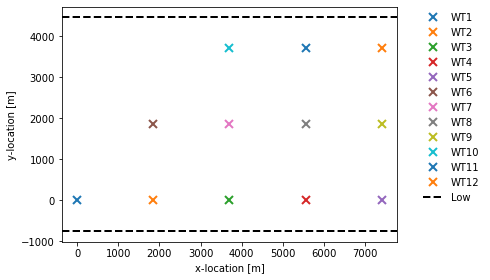

In [16]:
currentTS.plotSetup()

### Low-res box: Prepare SLURM script and submit job

In [18]:
# --------------------------------------------------
# ----- Prepare SLURM script for Low-res boxes -----
# --------------------------------------------------

import subprocess
status = os.system(f'cp {templatePath}/runAllLowBox.sh {path}/runAllLowBox.sh')

# Change job name (for convenience only)
_ = subprocess.call(f"sed -i 's|#SBATCH --job-name=lowBox|#SBATCH --job-name=lowBox_{os.path.basename(path)}|g' runAllLowBox.sh", cwd=path, shell=True)
# Change the path inside the script to the desired one
sed_command = f"sed -i 's|/projects/shellwind/rthedin/Task2_2regis|{path}|g' runAllLowBox.sh"
_ = subprocess.call(sed_command, cwd=path, shell=True)
# Change number of nodes values 
_ = subprocess.call(f"sed -i 's|#SBATCH --nodes=2|#SBATCH --nodes={int(np.ceil(nConditions*nSeeds/6))}|g' runAllLowBox.sh", cwd=path, shell=True)
# Assemble list of conditions and write it
listtoprint = "' '".join(condDirList)
sed_command = f"""sed -i "s|^condList.*|condList=('{listtoprint}')|g" runAllLowBox.sh"""
_ = subprocess.call(sed_command, cwd=path, shell=True)

In [19]:
# ---------------------------------
# ----- Run turbSim Low boxes -----
# ---------------------------------
# Submit the script to SLURM
_ = subprocess.call('sbatch runAllLowBox.sh', cwd=path, shell=True)

Submitted batch job 10392091


### Low-res box: create symlinks

In [ ]:
# Create symbolic links for all of the time-series and the Low.bts files too

notepath = os.getcwd()
os.chdir(path)
for cond in range(nConditions):
    for case in range(nCases):
        for seed in range(nSeeds):
            try:
                src = os.path.join('../../../..', condDirList[cond], f'Seed_{seed}', 'Low.bts')
                dst = os.path.join(condDirList[cond], caseDirList[case], f'Seed_{seed}', 'TurbSim', 'Low.bts')
                os.symlink(src, dst)                
            except FileExistsError:
                print(f'File {dst} already exists. Skipping symlink.')
os.chdir(notepath)


## High-res box: TurbSim setup
Turbine numbering is 1-indexing

In [ ]:
# Figure out how many (and which) high boxes actually need to be executed. Remember that wake steering, yaw misalignment, SED/ADsk models,
# and sweep in yaw do not require extra TurbSim runs
#nHighBoxCases = nWindDir
nHighBoxCases = len(np.unique(inflow_deg))  # some wind dir might be repeated for sweep on yaws

allHighBoxCases = allCases.where(~allCases['wakeSteering'],drop=True).drop_vars('wakeSteering')\
                          .where(~allCases['misalignment'], drop=True).drop_vars('misalignment')\
                          .where(allCases['nFullAeroDyn']==nTurbines, drop=True).drop_vars('ADmodel')\
                          .where(allCases['nFulllElastoDyn']==nTurbines, drop=True).drop_vars('EDmodel')\
                          .where(allCases['yawCase']==1, drop=True).drop_vars('yawCase')

if nHighBoxCases != len(allHighBoxCases.case):
    raise ValueError(f'The number of cases do not match as expected. {nHighBoxCases} unique wind directions, but {len(allHighBoxCases.case)} unique cases.')

In [ ]:
# Determine offsets from turbines coordinate frame to TurbSim coordinate frame
yoffset_turbsOrigin2TSOrigin = -( (currentTS.ymax - currentTS.ymin)/2 + currentTS.ymin )
xoffset_turbsOrigin2TSOrigin = - extent_low[0]*D

print(f"The y offset between the turbine ref frame and turbsim is {yoffset_turbsOrigin2TSOrigin}")
print(f"The x offset between the turbine ref frame and turbsim is {xoffset_turbsOrigin2TSOrigin}")

### High-res box: Open Low-res boxes and extract time-series at turbine locations
Not exactly at the locations the turbines were specified to be at, but rather at the nearest grid point.

In [18]:
# Loop on all conditions/seeds extracting time series from the Low box at turbines location
boxType='highres'
for cond in range(nConditions):
    for seed in range(nSeeds):
        condSeedPath = os.path.join(path, condDirList[cond], f'Seed_{seed}')

        # Read output .bts for current seed
        bts = TurbSimFile(os.path.join(condSeedPath, 'Low.bts'))
        bts['t']  = np.round(bts['t'],  6) # rounding single precision read as double precision
        bts['dt'] = np.round(bts['dt'], 6)

        for case in range(nHighBoxCases):
            # Get actual case number given the high-box that need to be saved
            case = allHighBoxCases.isel(case=case)['case'].values
            
            caseSeedPath = os.path.join(path, condDirList[cond], caseDirList[case], f'Seed_{seed}', 'TurbSim')
            
            for t in range(nTurbines):
                # Recover turbine properties. Using turbine locations related to aligned inflow case
                # alignedCase = allCases.where(allCases.inflow_deg==0, drop=True).isel(case=0)
                # HubHt_   = alignedCase.sel(turbine=t)['zhub'].values
                # xloc_    = alignedCase.sel(turbine=t)['Tx'  ].values
                # yloc_    = alignedCase.sel(turbine=t)['Ty'  ].values
                
                # Recover turbine properties of the current case
                HubHt_   = allCases.sel(case=case, turbine=t)['zhub'].values
                xloc_    = allCases.sel(case=case, turbine=t)['Tx'  ].values
                yloc_    = allCases.sel(case=case, turbine=t)['Ty'  ].values

                # Turbine location in TurbSim reference frame
                xt = xloc_ + xoffset_turbsOrigin2TSOrigin
                yt = yloc_ + yoffset_turbsOrigin2TSOrigin

                # Get indices of turbine location in TurbSim files
                jTurb, kTurb = bts.closestPoint(y=yt,z=HubHt_)
                Hub_series = bts['z'][kTurb]

                # Get indices of the half height position (TurbSim's hub height)
                jMid, kMid = bts.iMid

                # Get time series at the box center to get mean vhub and create time array. JJ: get at the Turbsim hub height
                #Vhub = bts['u'][0,:,jTurb,kTurb]
                Vmid = bts['u'][0,:,jMid,kMid]
                time = bts.t

                # The time-series need to be shifted depending on the turbine location, so we need to find how many
                # grid points (time steps) the data have convected. We use the mean streamwise component for that
                start_time_step = round( (xt/Vmid.mean())/bts.dt ) 

                # Get time-series given rolling
                uvel = np.roll(bts['u'][0, :, jTurb, kTurb], start_time_step)
                vvel = np.roll(bts['u'][1, :, jTurb, kTurb], start_time_step)
                wvel = np.roll(bts['u'][2, :, jTurb, kTurb], start_time_step)

                # Checks
                assert len(time)==len(uvel)
                assert len(uvel)==len(vvel)
                assert len(vvel)==len(wvel)

                # Save timeseries as CondXX/Seed_Z/USRTimeSeries_T*.txt. This file will later be copied to CondXX/CaseYY/Seed_Z
                timeSeriesOutputFile = os.path.join(caseSeedPath, f'USRTimeSeries_T{t+1}.txt')

                # The reference frame used in the time-series is the inertial frame of the high-res box (local).
                # Sometimes the point where we want to place the turbine at exists and then we can set y=0. For example, suppose the low-res
                # grid has y = ..., 980, 1000, 1020, ..., and we want to place a turbine at y=1000. The low-res box has 5m resolution. Then,
                # the time-series will be pulled from _exactly_ y=1000, and since the low-res grid has a grid point there too, so we can put
                # y=0 on the time-series input file. However, if we want the turbine at y=998, we must account for the difference since this 
                # y value is not a grid point of the low-res box. So we compute an offset between the turbine location and the nearest grid
                # point in the low-res box, and then pass this offset to the time-series file. In this example, the offset is 2 m, thus the
                # time-series file will have a y of 2 m.
                yoffset = bts['y'][jTurb] - yt
                if yoffset != 0:
                    print(f"Turbine {t+1} is not at a grid point location. Tubine is at y={yloc_} on the turbine reference frame, which is y="
                          f"{yt} on the low-res TurbSim reference frame. The nearest grid point in y is {bts['y'][jTurb]}",\
                          f"so printing y={yoffset} to the time-series file.")
                writeTimeSeriesFile(timeSeriesOutputFile, yoffset, Hub_series, uvel, vvel, wvel, time)


Turbine 1 is not at a grid point location. Tubine is at y=0.0 on the turbine reference frame, which is y=-1852.0 on the low-res TurbSim reference frame. The nearest grid point in y is -1850.0 so printing y=2.0 to the time-series file.
Writing /projects/shellwind/rthedin/task_equinor/Cond00_v08.6_PL0.2_TI10/Case00_wdirp00_WSfalse_YMfalse_12fED_12ADyn/Seed_0/TurbSim/USRTimeSeries_T1.txt
Turbine 2 is not at a grid point location. Tubine is at y=0.0 on the turbine reference frame, which is y=-1852.0 on the low-res TurbSim reference frame. The nearest grid point in y is -1850.0 so printing y=2.0 to the time-series file.
Writing /projects/shellwind/rthedin/task_equinor/Cond00_v08.6_PL0.2_TI10/Case00_wdirp00_WSfalse_YMfalse_12fED_12ADyn/Seed_0/TurbSim/USRTimeSeries_T2.txt
Turbine 3 is not at a grid point location. Tubine is at y=0.0 on the turbine reference frame, which is y=-1852.0 on the low-res TurbSim reference frame. The nearest grid point in y is -1850.0 so printing y=2.0 to the time-se

### High-res box: Create High-res boxes input files for unique cases within each condition

In [20]:
# Loop on all conditions/cases/seeds setting up the High boxes
boxType='highres'
for cond in range(nConditions):
    for case in range(nHighBoxCases):
        # Get actual case number given the high-box that need to be saved
        case = allHighBoxCases.isel(case=case)['case'].values
        for seed in range(nSeeds):
            seedPath = os.path.join(path, condDirList[cond], caseDirList[case], f'Seed_{seed}', 'TurbSim')

            for t in range(nTurbines):

                # ---------------- TurbSim High boxes setup ------------------ #
                currentTSHighFile = os.path.join(seedPath, f'HighT{t+1}_stillToBeModified.inp')

                # Get properties needed for the creation of the high-res turbsim inp file
                D_       = allCases.sel(case=case, turbine=t)['D'   ].values
                HubHt_   = allCases.sel(case=case, turbine=t)['zhub'].values
                xloc_    = allCases.sel(case=case, turbine=t)['Tx'  ].values
                yloc_    = allCases.sel(case=case, turbine=t)['Ty'  ].values
                Vhub_    = allCond.sel(cond=cond)['vhub'   ].values
                shear_   = allCond.sel(cond=cond)['shear'  ].values
                tivalue_ = allCond.sel(cond=cond)['TIvalue'].values
                
                # Coherence parameters
                a = 12;  b=0.12                            # IEC 61400-3 ed4, app C, eq C.16
                Lambda1 = 0.7*HubHt_ if HubHt_<60 else 42  # IEC 61400-3 ed4, sec 6.3.1, eq 5 

                # Create and write new Low.inp files creating the proper box with proper resolution
                currentTS = TSCaseCreation(D_, HubHt_, Vhub_, tivalue_, shear_, x=xloc_, y=yloc_, zbot=zbot,
                                           cmax=cmax, fmax=fmax, Cmeander=Cmeander, boxType=boxType, high_ext=extent_high)
                currentTS.writeTSFile(turbSimHighFile, currentTSHighFile, tmax=tmax, turb=t)

                # Modify some values and save file (some have already been set in the call above)
                Highinp = FASTInputFile(currentTSHighFile)
                Highinp['RandSeed1'] = seedValues[seed]
                Highinp['TimeStep']  = 1/(2*fmax)
                Highinp['TurbModel'] = f'"TIMESR"'
                Highinp['UserFile']  = f'"USRTimeSeries_T{t+1}.txt"'
                Highinp['RefHt']     = HubHt_
                Highinp['URef']      = Vhub_
                Highinp['PLExp']     = shear_
                Highinp['latitude']  = latitude
                Highinp['InCDec1']   = Highinp['InCDec2'] = Highinp['InCDec3'] = f'"{a} {b/(8.1*Lambda1):.8f}"'
                Highinp.write( os.path.join(seedPath, f'HighT{t+1}.inp') )
        
                # Let's remove the original file
                os.remove(os.path.join(seedPath, f'HighT{t+1}_stillToBeModified.inp'))

Writing a new /projects/shellwind/rthedin/task_equinor/Cond00_v08.6_PL0.2_TI10/Case00_wdirp00_WSfalse_YMfalse_12fED_12ADyn/Seed_0/TurbSim/HighT1_stillToBeModified.inp file from scratch
Writing a new /projects/shellwind/rthedin/task_equinor/Cond00_v08.6_PL0.2_TI10/Case00_wdirp00_WSfalse_YMfalse_12fED_12ADyn/Seed_0/TurbSim/HighT2_stillToBeModified.inp file from scratch
Writing a new /projects/shellwind/rthedin/task_equinor/Cond00_v08.6_PL0.2_TI10/Case00_wdirp00_WSfalse_YMfalse_12fED_12ADyn/Seed_0/TurbSim/HighT3_stillToBeModified.inp file from scratch
Writing a new /projects/shellwind/rthedin/task_equinor/Cond00_v08.6_PL0.2_TI10/Case00_wdirp00_WSfalse_YMfalse_12fED_12ADyn/Seed_0/TurbSim/HighT4_stillToBeModified.inp file from scratch
Writing a new /projects/shellwind/rthedin/task_equinor/Cond00_v08.6_PL0.2_TI10/Case00_wdirp00_WSfalse_YMfalse_12fED_12ADyn/Seed_0/TurbSim/HighT5_stillToBeModified.inp file from scratch
Writing a new /projects/shellwind/rthedin/task_equinor/Cond00_v08.6_PL0.2_T

### High-res box: Prepare SLURM script and submit job

For the high boxes, we can take all 36 cores on each node and will not run out of memory. So no additional node binding is required. We just need to make sure we know the number of cases to be executed and request the correct number of nodes.

In [21]:
# adjust the list of cases using allHighBoxCases variable

In [22]:
# ---------------------------------------------------
# ----- Prepare SLURM script for High-res boxes -----
# ---------------------------------------------------

ntasks = nConditions*nHighBoxCases*nSeeds*nTurbines
status = os.system(f'cp {templatePath}/runAllHighBox.sh {path}/runAllHighBox.sh')

# Change job name (for convenience only)
_ = subprocess.call(f"sed -i 's|#SBATCH --job-name=highBox|#SBATCH --job-name=highBox_{os.path.basename(path)}|g' runAllHighBox.sh", cwd=path, shell=True)
# Change the path inside the script to the desired one
sed_command = f"sed -i 's|/projects/shellwind/rthedin/Task2_2regis|{path}|g' runAllHighBox.sh"
_ = subprocess.call(sed_command, cwd=path, shell=True)
# Change number of turbines
_ = subprocess.call(f"sed -i 's|nTurbines=12|nTurbines={nTurbines}|g'      runAllHighBox.sh", cwd=path, shell=True)
# Change number of nodes values
_ = subprocess.call(f"sed -i 's|#SBATCH --nodes=3|#SBATCH --nodes={int(np.ceil(ntasks/36))}|g' runAllHighBox.sh", cwd=path, shell=True)
# Assemble list of conditions and write it
listtoprint = "' '".join(condDirList)
sed_command = f"""sed -i "s|^condList.*|condList=('{listtoprint}')|g" runAllHighBox.sh"""
_ = subprocess.call(sed_command, cwd=path, shell=True)
# Assemble list of cases and write it
listtoprint = "' '".join(caseDirList)
sed_command = f"""sed -i "s|^caseList.*|caseList=('{listtoprint}')|g" runAllHighBox.sh"""
_ = subprocess.call(sed_command, cwd=path, shell=True)

In [34]:
# ----------------------------------
# ----- Run turbSim High boxes -----
# ----------------------------------
# Submit the script to SLURM
_ = subprocess.call('sbatch runAllHighBox.sh', cwd=path, shell=True)

Submitted batch job 10083151


### High-res box: Create symbolic link for the high-res boxes for cases with wake steering and yaw misalignment

In [18]:
# Create symlink of all the high boxes for the cases with wake steering and yaw misalignment. These are the "repeated" boxes

notepath = os.getcwd()
os.chdir(path)
for cond in range(nConditions):
    for t in range(nTurbines):
        for seed in range(nSeeds):
            for case in range(nCases):
                # Let's check if the current case is source (has bts) or destination (needs a symlink to bts)
                varsToDrop = ['wakeSteering','misalignment','yawmis','yaw','ADmodel','EDmodel','nFullAeroDyn','nFulllElastoDyn']
                if case in allHighBoxCases['case']:
                    src = os.path.join('../../../..', condDirList[cond], caseDirList[case], f'Seed_{seed}', 'TurbSim', f'HighT{t+1}.bts')
                    xr_src = allCases.sel(case=0, drop=True).drop_vars(varsToDrop)
                    continue
                else:
                    dst = os.path.join(condDirList[cond], caseDirList[case], f'Seed_{seed}', 'TurbSim', f'HighT{t+1}.bts')
                    xr_dst = allCases.sel(case=3, drop=True).drop_vars(varsToDrop)
                    
                # Let's make sure the src and destination are the same case, except wake steering and yaw misalign bools
                xr.testing.assert_equal(xr_src, xr_dst)
                
                try:
                    os.symlink(src, dst)
                except FileExistsError:
                    print(f'File {dst} already exists. Skipping symlink.')
os.chdir(notepath)

## Sanity check on time-history at hub height for both low- and high-res boxes

In [19]:
turb = 6

# Open low and high box
lowinflow  = TurbSimFile(os.path.join(path,'Cond00_v08.6_PL0.2_TI10/Seed_0/Low.bts'))
highinflow = TurbSimFile(os.path.join(path,f'Cond00_v08.6_PL0.2_TI10/Case00_wdirp00_WSfalse_YMfalse_12fED_12ADyn//Seed_0/TurbSim/HighT{turb}.bts'))

# Read the time series given as a file
tsfile = os.path.join(path,f'Cond00_v08.6_PL0.2_TI10/Case00_wdirp00_WSfalse_YMfalse_12fED_12ADyn/Seed_0/TurbSim/USRTimeSeries_T{turb}.txt')
timeseries = pd.read_csv(tsfile, skiprows=12, sep="\s+|;|:", engine='python', header=None, names=['t','u','v','w'])

In [20]:
alignedCase = allCases.where(allCases.inflow_deg==0, drop=True).isel(case=0)
HubHt_   = alignedCase.sel(turbine=turb-1)['zhub'].values
xloc_    = alignedCase.sel(turbine=turb-1)['Tx'  ].values
yloc_    = alignedCase.sel(turbine=turb-1)['Ty'  ].values

# Turbine location in TurbSim reference frame
xt = xloc_ + xoffset_turbsOrigin2TSOrigin
yt = yloc_ + yoffset_turbsOrigin2TSOrigin
            
jTurb_low, kTurb_low = lowinflow.closestPoint(y=yt,z=HubHt_)
jTurb_high, kTurb_high = highinflow.closestPoint(y=0,z=HubHt_)

yyl, zzl = np.meshgrid(lowinflow.y,  lowinflow.z,  indexing='ij')
yyh, zzh = np.meshgrid(highinflow.y, highinflow.z, indexing='ij')

if False:
    print(f"Hub is at x={xloc_}, y={yloc_}, z={HubHt_}")
    print(f"In TurbSim reference frame, y={yt}, z={lowinflow['z'][kTurb_low]}")

    print(f"Low: The position of the hub at the closest grid point in the low-res domain is  y={lowinflow['y'][jTurb_low]}, z={lowinflow['z'][kTurb_low]}")
    print(f"Time series were sampled from the low box at y={lowinflow['y'][jTurb_low]}, z={lowinflow['z'][kTurb_low]}")
    print(f"The location printed on the time-series file given to the high box is y=0, z={HubHt_}\n")

    print(f"High: The position of the hub at the closest grid point in the high-res domain is y={highinflow['y'][jTurb_high]}, z={highinflow['z'][kTurb_high]}\n")

    print(f"Low: The grid points around the hub location are  y={lowinflow['y'][jTurb_low-2:jTurb_low+3]},   \tz={lowinflow['z'][kTurb_low-2:kTurb_low+3]}")
    print(f"High: The grid points around the hub locations are y={highinflow['y'][jTurb_high-2:jTurb_high+3]},  \tz={highinflow['z'][kTurb_high-2:kTurb_high+3]}\n")

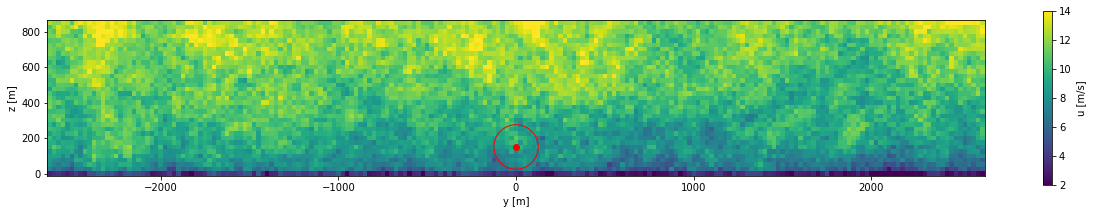

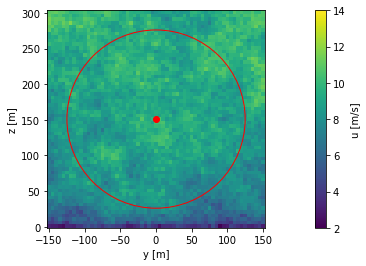

In [21]:
fig, ax = plt.subplots(ncols=1, figsize=(21,3.2))
cm = ax.pcolormesh(yyl, zzl, lowinflow['u'][0,3,:,:], vmin=2, vmax=14)
fig.colorbar(cm, ax=ax, label='u [m/s]')
ax.scatter(lowinflow['y'][jTurb_low], lowinflow['z'][kTurb_low], c='r')
ax.add_patch(plt.Circle((lowinflow['y'][jTurb_low], lowinflow['z'][kTurb_low]), D/2, color='r', fill=False))
ax.set_ylabel('z [m]'); ax.set_xlabel('y [m]')
ax.set_aspect('equal')

fig, ax = plt.subplots(ncols=1, figsize=(18,4))
cm = ax.pcolormesh(yyh, zzh, highinflow['u'][0,3,:,:], vmin=2, vmax=14)
fig.colorbar(cm, ax=ax, label='u [m/s]')
ax.scatter(highinflow['y'][jTurb_high], highinflow['z'][kTurb_high], c='r')
ax.add_patch(plt.Circle((highinflow['y'][jTurb_high], highinflow['z'][kTurb_high]), D/2, color='r', fill=False))
ax.set_ylabel('z [m]'); ax.set_xlabel('y [m]')
ax.set_aspect('equal')

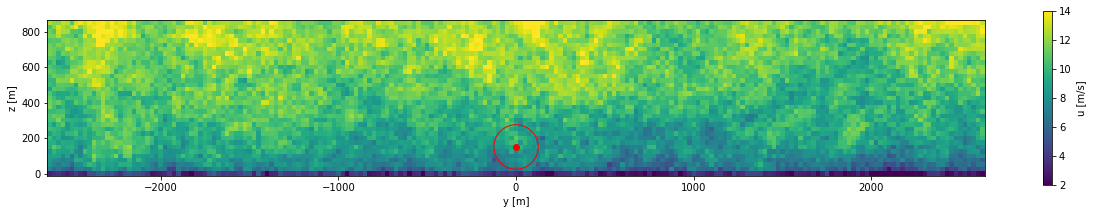

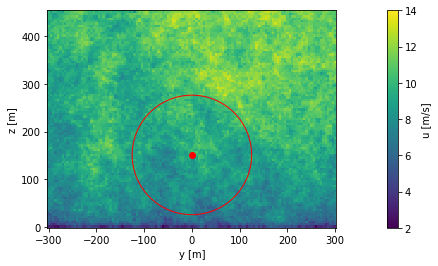

In [38]:
# old, larger box

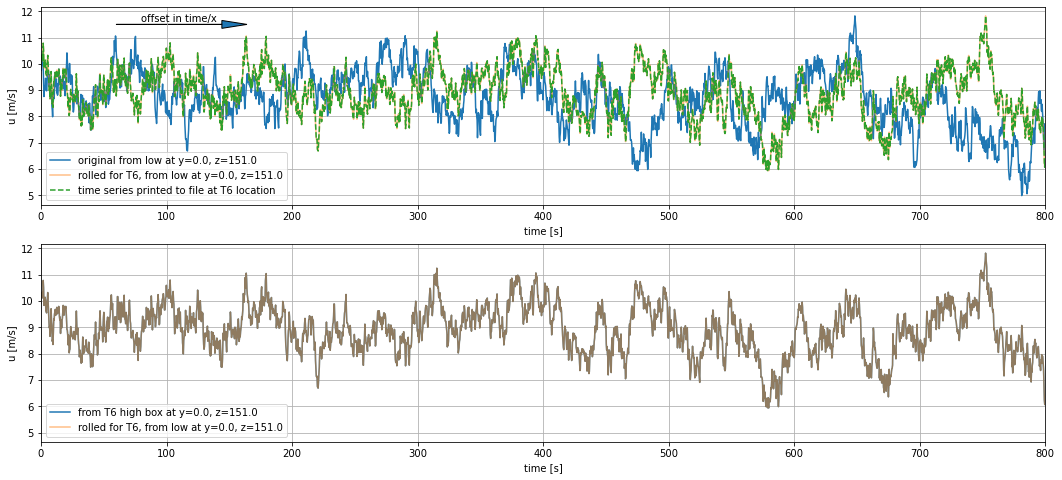

In [22]:
# compute rolled data from low res
jMid, kMid = lowinflow.iMid
            
# Get time series at hub location to get mean vhub and create time array. JJ: get at the Turbsim hub height
Vmid = lowinflow['u'][0,:,jMid,kMid]
start_time_step = round( (xt/Vmid.mean())/lowinflow.dt ) 
uvel = np.roll(lowinflow['u'][0, :, jTurb_low, kTurb_low], start_time_step)
            
fig, axs = plt.subplots(nrows=2, figsize=(18,8))

axs[0].plot(lowinflow['t'], lowinflow['u'][0,:,jTurb_low, kTurb_low], label=f"original from low at y={lowinflow['y'][jTurb_low]}, z={lowinflow['z'][kTurb_low]}")
axs[0].plot(lowinflow['t'], uvel,                                     label=f"rolled for T{turb}, from low at y={lowinflow['y'][jTurb_low]}, z={lowinflow['z'][kTurb_low]}", alpha=0.5)
axs[0].plot(timeseries['t'], timeseries['u'],                         label=f'time series printed to file at T{turb} location ', ls='--')
axs[0].arrow(60, 11.5, lowinflow.dt*start_time_step, 0, length_includes_head=True, head_width=0.3, head_length=20)
axs[0].annotate("offset in time/x", xy=(80,11.6))
#axs[0].set_xlim([0,250])

axs[1].plot(highinflow['t'], highinflow['u'][0,:,jTurb_high, kTurb_high], label=f"from T{turb} high box at y={highinflow['y'][jTurb_high]}, z={highinflow['z'][kTurb_high]}")
axs[1].plot(lowinflow['t'], uvel,                                         label=f"rolled for T{turb}, from low at y={lowinflow['y'][jTurb_low]}, z={lowinflow['z'][kTurb_low]}", alpha=0.5)


for ax in axs:
    ax.grid()
    ax.legend()
    ax.set_xlim([0,800])
    ax.set_xlabel('time [s]')
    ax.set_ylabel('u [m/s]')

## FAST.Farm

In [23]:
# Output list for FAST.Farm runs. Use 1 at the end for turbines (they will be replicated for all turbines). Combination of sample input file and KS's input
outlistFF = [
    "RtAxsXT1     , RtAxsYT1     , RtAxsZT1",
    "RtPosXT1     , RtPosYT1     , RtPosZT1",
    "RtDiamT1",
    "YawErrT1",
    "TIAmbT1",
    'RtVAmbT1',
    'RtVRelT1',
    'W1VAmbX, W1VAmbY, W1VAmbZ',
    "W1VDisX, W1VDisY, W1VDisZ",
    "CtT1N01      , CtT1N02      , CtT1N03      , CtT1N04      , CtT1N05      , CtT1N06      , CtT1N07      , CtT1N08      , CtT1N09      , CtT1N10      , CtT1N11      , CtT1N12      , CtT1N13      , CtT1N14      , CtT1N15      , CtT1N16      , CtT1N17      , CtT1N18      , CtT1N19      ,  CtT1N20",
#    "WkAxsXT1D1   , WkAxsXT1D2   , WkAxsXT1D3   , WkAxsXT1D4   , WkAxsXT1D5   , WkAxsXT1D6   , WkAxsXT1D7",
#    "WkAxsYT1D1   , WkAxsYT1D2   , WkAxsYT1D3   , WkAxsYT1D4   , WkAxsYT1D5   , WkAxsYT1D6   , WkAxsYT1D7",
#    "WkAxsZT1D1   , WkAxsZT1D2   , WkAxsZT1D3   , WkAxsZT1D4   , WkAxsZT1D5   , WkAxsZT1D6   , WkAxsZT1D7",
#    "WkPosXT1D1   , WkPosXT1D2   , WkPosXT1D3   , WkPosXT1D4   , WkPosXT1D5   , WkPosXT1D6   , WkPosXT1D7",
#    "WkPosYT1D1   , WkPosYT1D2   , WkPosYT1D3   , WkPosYT1D4   , WkPosYT1D5   , WkPosYT1D6   , WkPosYT1D7",
#    "WkPosZT1D1   , WkPosZT1D2   , WkPosZT1D3   , WkPosZT1D4   , WkPosZT1D5   , WkPosZT1D6   , WkPosZT1D7",
#    "WkDfVxT1N01D1, WkDfVxT1N02D1, WkDfVxT1N03D1, WkDfVxT1N04D1, WkDfVxT1N05D1, WkDfVxT1N06D1, WkDfVxT1N07D1, WkDfVxT1N08D1, WkDfVxT1N09D1, WkDfVxT1N10D1, WkDfVxT1N11D1, WkDfVxT1N12D1, WkDfVxT1N13D1, WkDfVxT1N14D1, WkDfVxT1N15D1, WkDfVxT1N16D1, WkDfVxT1N17D1, WkDfVxT1N18D1, WkDfVxT1N19D1, WkDfVxT1N20D1",
#    "WkDfVxT1N01D2, WkDfVxT1N02D2, WkDfVxT1N03D2, WkDfVxT1N04D2, WkDfVxT1N05D2, WkDfVxT1N06D2, WkDfVxT1N07D2, WkDfVxT1N08D2, WkDfVxT1N09D2, WkDfVxT1N10D2, WkDfVxT1N11D2, WkDfVxT1N12D2, WkDfVxT1N13D2, WkDfVxT1N14D2, WkDfVxT1N15D2, WkDfVxT1N16D2, WkDfVxT1N17D2, WkDfVxT1N18D2, WkDfVxT1N19D2, WkDfVxT1N20D2",
#    "WkDfVxT1N01D3, WkDfVxT1N02D3, WkDfVxT1N03D3, WkDfVxT1N04D3, WkDfVxT1N05D3, WkDfVxT1N06D3, WkDfVxT1N07D3, WkDfVxT1N08D3, WkDfVxT1N09D3, WkDfVxT1N10D3, WkDfVxT1N11D3, WkDfVxT1N12D3, WkDfVxT1N13D3, WkDfVxT1N14D3, WkDfVxT1N15D3, WkDfVxT1N16D3, WkDfVxT1N17D3, WkDfVxT1N18D3, WkDfVxT1N19D3, WkDfVxT1N20D3",
#    "WkDfVxT1N01D4, WkDfVxT1N02D4, WkDfVxT1N03D4, WkDfVxT1N04D4, WkDfVxT1N05D4, WkDfVxT1N06D4, WkDfVxT1N07D4, WkDfVxT1N08D4, WkDfVxT1N09D4, WkDfVxT1N10D4, WkDfVxT1N11D4, WkDfVxT1N12D4, WkDfVxT1N13D4, WkDfVxT1N14D4, WkDfVxT1N15D4, WkDfVxT1N16D4, WkDfVxT1N17D4, WkDfVxT1N18D4, WkDfVxT1N19D4, WkDfVxT1N20D4",
#    "WkDfVxT1N01D5, WkDfVxT1N02D5, WkDfVxT1N03D5, WkDfVxT1N04D5, WkDfVxT1N05D5, WkDfVxT1N06D5, WkDfVxT1N07D5, WkDfVxT1N08D5, WkDfVxT1N09D5, WkDfVxT1N10D5, WkDfVxT1N11D5, WkDfVxT1N12D5, WkDfVxT1N13D5, WkDfVxT1N14D5, WkDfVxT1N15D5, WkDfVxT1N16D5, WkDfVxT1N17D5, WkDfVxT1N18D5, WkDfVxT1N19D5, WkDfVxT1N20D5",
#    "WkDfVxT1N01D6, WkDfVxT1N02D6, WkDfVxT1N03D6, WkDfVxT1N04D6, WkDfVxT1N05D6, WkDfVxT1N06D6, WkDfVxT1N07D6, WkDfVxT1N08D6, WkDfVxT1N09D6, WkDfVxT1N10D6, WkDfVxT1N11D6, WkDfVxT1N12D6, WkDfVxT1N13D6, WkDfVxT1N14D6, WkDfVxT1N15D6, WkDfVxT1N16D6, WkDfVxT1N17D6, WkDfVxT1N18D6, WkDfVxT1N19D6, WkDfVxT1N20D6",
#    "WkDfVxT1N01D7, WkDfVxT1N02D7, WkDfVxT1N03D7, WkDfVxT1N04D7, WkDfVxT1N05D7, WkDfVxT1N06D7, WkDfVxT1N07D7, WkDfVxT1N08D7, WkDfVxT1N09D7, WkDfVxT1N10D7, WkDfVxT1N11D7, WkDfVxT1N12D7, WkDfVxT1N13D7, WkDfVxT1N14D7, WkDfVxT1N15D7, WkDfVxT1N16D7, WkDfVxT1N17D7, WkDfVxT1N18D7, WkDfVxT1N19D7, WkDfVxT1N20D7",
#    "WkDfVrT1N01D1, WkDfVrT1N02D1, WkDfVrT1N03D1, WkDfVrT1N04D1, WkDfVrT1N05D1, WkDfVrT1N06D1, WkDfVrT1N07D1, WkDfVrT1N08D1, WkDfVrT1N09D1, WkDfVrT1N10D1, WkDfVrT1N11D1, WkDfVrT1N12D1, WkDfVrT1N13D1, WkDfVrT1N14D1, WkDfVrT1N15D1, WkDfVrT1N16D1, WkDfVrT1N17D1, WkDfVrT1N18D1, WkDfVrT1N19D1, WkDfVrT1N20D1",
#    "WkDfVrT1N01D2, WkDfVrT1N02D2, WkDfVrT1N03D2, WkDfVrT1N04D2, WkDfVrT1N05D2, WkDfVrT1N06D2, WkDfVrT1N07D2, WkDfVrT1N08D2, WkDfVrT1N09D2, WkDfVrT1N10D2, WkDfVrT1N11D2, WkDfVrT1N12D2, WkDfVrT1N13D2, WkDfVrT1N14D2, WkDfVrT1N15D2, WkDfVrT1N16D2, WkDfVrT1N17D2, WkDfVrT1N18D2, WkDfVrT1N19D2, WkDfVrT1N20D2",
#    "WkDfVrT1N01D3, WkDfVrT1N02D3, WkDfVrT1N03D3, WkDfVrT1N04D3, WkDfVrT1N05D3, WkDfVrT1N06D3, WkDfVrT1N07D3, WkDfVrT1N08D3, WkDfVrT1N09D3, WkDfVrT1N10D3, WkDfVrT1N11D3, WkDfVrT1N12D3, WkDfVrT1N13D3, WkDfVrT1N14D3, WkDfVrT1N15D3, WkDfVrT1N16D3, WkDfVrT1N17D3, WkDfVrT1N18D3, WkDfVrT1N19D3, WkDfVrT1N20D3",
#    "WkDfVrT1N01D4, WkDfVrT1N02D4, WkDfVrT1N03D4, WkDfVrT1N04D4, WkDfVrT1N05D4, WkDfVrT1N06D4, WkDfVrT1N07D4, WkDfVrT1N08D4, WkDfVrT1N09D4, WkDfVrT1N10D4, WkDfVrT1N11D4, WkDfVrT1N12D4, WkDfVrT1N13D4, WkDfVrT1N14D4, WkDfVrT1N15D4, WkDfVrT1N16D4, WkDfVrT1N17D4, WkDfVrT1N18D4, WkDfVrT1N19D4, WkDfVrT1N20D4",
#    "WkDfVrT1N01D5, WkDfVrT1N02D5, WkDfVrT1N03D5, WkDfVrT1N04D5, WkDfVrT1N05D5, WkDfVrT1N06D5, WkDfVrT1N07D5, WkDfVrT1N08D5, WkDfVrT1N09D5, WkDfVrT1N10D5, WkDfVrT1N11D5, WkDfVrT1N12D5, WkDfVrT1N13D5, WkDfVrT1N14D5, WkDfVrT1N15D5, WkDfVrT1N16D5, WkDfVrT1N17D5, WkDfVrT1N18D5, WkDfVrT1N19D5, WkDfVrT1N20D5",
#    "WkDfVrT1N01D6, WkDfVrT1N02D6, WkDfVrT1N03D6, WkDfVrT1N04D6, WkDfVrT1N05D6, WkDfVrT1N06D6, WkDfVrT1N07D6, WkDfVrT1N08D6, WkDfVrT1N09D6, WkDfVrT1N10D6, WkDfVrT1N11D6, WkDfVrT1N12D6, WkDfVrT1N13D6, WkDfVrT1N14D6, WkDfVrT1N15D6, WkDfVrT1N16D6, WkDfVrT1N17D6, WkDfVrT1N18D6, WkDfVrT1N19D6, WkDfVrT1N20D6",
#    "WkDfVrT1N01D7, WkDfVrT1N02D7, WkDfVrT1N03D7, WkDfVrT1N04D7, WkDfVrT1N05D7, WkDfVrT1N06D7, WkDfVrT1N07D7, WkDfVrT1N08D7, WkDfVrT1N09D7, WkDfVrT1N10D7, WkDfVrT1N11D7, WkDfVrT1N12D7, WkDfVrT1N13D7, WkDfVrT1N14D7, WkDfVrT1N15D7, WkDfVrT1N16D7, WkDfVrT1N17D7, WkDfVrT1N18D7, WkDfVrT1N19D7, WkDfVrT1N20D7",
]

In [24]:
# Planes to save in FAST.Farm. We want the planes through the original farm, so let's get the position of the turbines at wdir=0
alignedTurbs = allCases.where(allCases['inflow_deg']==0, drop=True).isel(case=0)
# Turbine location in TurbSim reference frame
xt = alignedTurbs['Tx'].values + xoffset_turbsOrigin2TSOrigin
yt = alignedTurbs['Ty'].values + yoffset_turbsOrigin2TSOrigin

offset=50
planes_xy = [151]   # !!!! this is 150. KS had 148.84 commented out. Check with JJ
planes_yz = np.unique(xt+offset)
planes_xz = np.unique(yt)

In [25]:
def getMultipleOf(val, multipleof):
    valmult = int(val/multipleof)*multipleof
    return round(valmult, 4)

In [26]:
def getBoxesParamsForFF(lowbts, highbts, dt_low_desired, extent_low, extent_high, D, HubHt, xWT, yt, verbose=False):
    # Get mean wind speeds at the half height location (advection speed)
    _, meanU_High =  highbts.midValues() # !!!!!!!!!!!!!!!! JJ: does it make sense to get both? the meanu for low will be a lot higher than vhub,
    _, meanU_Low  =  lowbts.midValues()  # !!!!!!!!!!!!!!!! and the meanu for high will be a bit higher than vhub

    dT_High = np.round(highbts.dt, 4) # 0.3
    # dX_High can sometimes be too high. So get the closest to the cmax, but multiple of what should have been
    dX_High = round(meanU_High*dT_High)
    print(f'original dX_High is {dX_High}')
    dX_High = round(cmax/dX_High) * dX_High
    print(f'after adjusting to closes multiple of cmax, dX_High is {dX_High}')
    dY_High = highbts.y[1] - highbts.y[0]
    dZ_High = highbts.z[1] - highbts.z[0]


    dT_Low = getMultipleOf(dt_low_desired, multipleof=dT_High)
    #dX_Low = getMultipleOf(meanU_Low*dT_Low, multipleof=dX_High) # this is 3. i want to get to a multuple closer to cmax, so 6
    dX_Low = getMultipleOf(meanU_Low*dT_Low, multipleof=dX_High) # dy and dz high are 5. 
    
    dY_Low = lowbts.y[1] - lowbts.y[0]
    dZ_Low = lowbts.z[1] - lowbts.z[0]




    LY_Low = lowbts.y[-1]-lowbts.y[0]
    LZ_Low = lowbts.z[-1]-lowbts.z[0]
    LT_Low = np.round(lowbts.t[-1]-lowbts.t[0], 4)

    X0_Low = np.floor( (min(xWT) - extent_low[0]*D ))# - dX_Low)) #  # !!!!!!! # removing EB's -dX_Low from the X0_Low specification
    X0_Low = getMultipleOf(X0_Low, multipleof=dX_Low)
    Y0_Low = np.floor( -LY_Low/2                   ) # Starting on integer value for aesthetics
    Z0_Low = lowbts.z[0]                             # we start at lowest to include tower

    XMax_Low = getMultipleOf(max(xWT) + extent_low[1]*D, multipleof=dX_Low)
    LX_Low = XMax_Low-X0_Low


    nX_Low = int(np.ceil(LX_Low/dX_Low)+1)  # plus 1 from the guidance
    nY_Low = len(lowbts.y) # !!!!!!! different from what EB has
    nZ_Low = len(lowbts.z) # !!!!!!!!!!!!!!!!!!! 

    assert nY_Low == int(np.ceil(LY_Low/dY_Low)+1)
    assert nZ_Low == int(np.ceil(LZ_Low/dZ_Low)+1)
    assert (nY_Low-1)*dY_Low == LY_Low
    assert (nZ_Low-1)*dZ_Low == LZ_Low






    #Max_High = HubHt+extent_high*D  # !!!!!!!!!!!!!!!!!! actual hh or midpoint?
    Z0_High   = highbts.z[0]        # we start at lowest to include tower

    LX_High = extent_high*D  # !!!!!! sep 29: I had 2*extent_high*D here: does that mean we have the same amount of planes as before, but now the LX_High is smaller 
    LY_High = highbts.y[-1]-highbts.y[0]                                                          # thus smaller DX_High?
    LZ_High = highbts.z[-1]-highbts.z[0]
    LT_High = np.round(highbts.t[-1]-highbts.t[0], 4)
    # !!!!!!!!!!!!!!!!! JJ: EB had these below. Why is that?
    #LY_High =  min(LY_Box, extent_YZ*D      ) # Bounding to not exceed the box dimension
    #LZ_High =  min(LZ_Box, ZMax_High-Z0_High) # Bounding to not exceed the box dimension

    nX_High = int(np.ceil(LX_High/dX_High) + 1)  # plus 1 from the guidance
    nY_High = len(highbts.y)
    nZ_High = len(highbts.z)

    assert nY_High == int(np.ceil(LY_High/dY_High)+1)
    assert nZ_High == int(np.ceil(LZ_High/dZ_High)+1)
    assert (nY_High-1)*dY_High == LY_High
    assert (nZ_High-1)*dZ_High == LZ_High

    #if (nY_High*dY_High>LY_Box): nY_High=nY_High-1
    #if (nZ_High*dZ_High>LZ_Box): nZ_High=nZ_High-1


    # --- High-res location per turbine
    X0_desired = np.asarray(xWT)-LX_High/2 # high-res is centered on turbine location
    Y0_desired = np.asarray(yt)-LY_High/2 # high-res is centered on turbine location
    X0_High    = X0_Low + np.floor((X0_desired-X0_Low)/dX_High)*dX_High
    Y0_High    = Y0_Low + np.floor((Y0_desired-Y0_Low)/dY_High)*dY_High

    if verbose:
        print(f'  Low Box  \t\t  High box   ')
        print(f'dT_Low: {dT_Low}\t\t dT_High: {dT_High}')
        print(f'dX_Low: {dX_Low}\t\t dX_High: {dX_High}')
        print(f'dY_Low: {dY_Low}\t\t dY_High: {dY_High}')
        print(f'dZ_Low: {dZ_Low}\t\t dZ_High: {dZ_High}')
        print(f'LX_Low: {LX_Low}\t\t LX_High: {LX_High}')
        print(f'LY_Low: {LY_Low}\t\t LY_High: {LY_High}')
        print(f'LZ_Low: {LZ_Low}\t\t LZ_High: {LZ_High}')
        print(f'LT_Low: {LT_Low}\t\t LT_High: {LT_High}')
        print(f'nX_Low: {nX_Low}\t\t nX_High: {nX_High}')
        print(f'nY_Low: {nY_Low}\t\t nY_High: {nY_High}')
        print(f'nZ_Low: {nZ_Low}\t\t nZ_High: {nZ_High}')
        print(f'X0_Low: {X0_Low}\t\t X0_High: {X0_High}')
        print(f'Y0_Low: {Y0_Low}  \t Y0_High: {Y0_High}')
        print(f'Z0_Low: {Z0_Low}\t\t Z0_High: {Z0_High}')


    # Fill dictionary with all values
    d = dict()
    d['DT_Low']      = np.around(dT_Low ,4)
    d['DT_High']     = np.around(dT_High,4)
    d['NX_Low']      = nX_Low
    d['NY_Low']      = nY_Low
    d['NZ_Low']      = nZ_Low
    d['X0_Low']      = np.around(X0_Low,4)
    d['Y0_Low']      = np.around(Y0_Low,4)
    d['Z0_Low']      = np.around(Z0_Low,4)
    d['dX_Low']      = np.around(dX_Low,4)
    d['dY_Low']      = np.around(dY_Low,4)
    d['dZ_Low']      = np.around(dZ_Low,4)
    d['NX_High']     = nX_High
    d['NY_High']     = nY_High
    d['NZ_High']     = nZ_High
    # --- High extent info for turbine outputs
    d['dX_High']     = np.around(dX_High,4)
    d['dY_High']     = np.around(dY_High,4)
    d['dZ_High']     = np.around(dZ_High,4)
    d['X0_High']     = np.around(X0_High,4)
    d['Y0_High']     = np.around(Y0_High,4)
    d['Z0_High']     = np.around(Z0_High,4)
    # --- Misc
    d['U_mean_Low']  = meanU_Low
    d['U_mean_High'] = meanU_High


    # --- Sanity check: check that the high res is at "almost" an integer location
    X_rel = (np.array(d['X0_High'])-d['X0_Low'])/d['dX_High']
    Y_rel = (np.array(d['Y0_High'])-d['Y0_Low'])/d['dY_High']
    dX = X_rel - np.round(X_rel) # Should be close to zero
    dY = Y_rel - np.round(Y_rel) # Should be close to zero

    if any(abs(dX)>1e-3):
        print('Deltas:',dX)
        raise Exception('Some X0_High are not on an integer multiple of the high-res grid')
    if any(abs(dY)>1e-3):
        print('Deltas:',dY)
        raise Exception('Some Y0_High are not on an integer multiple of the high-res grid')
        
    return d

In [27]:
cond=0
case=0
seed=0

seedPath = os.path.join(path, condDirList[cond], caseDirList[case], f'Seed_{seed}')

# Recover case properties
D_       = allCases['D'   ].max().values # Getting the maximum in case different turbines are present
HubHt_   = allCases['zhub'].max().values # Getting the maximum in case different turbines are present
Vhub_    = allCond.sel(cond=cond)['vhub'   ].values
shear_   = allCond.sel(cond=cond)['shear'  ].values
tivalue_ = allCond.sel(cond=cond)['TIvalue'].values
# Recover turbine properties (array of length nTurbines)
xWT = allCases.sel(case=case)['Tx'].values
yWT = allCases.sel(case=case)['Ty'].values
zWT = allCases.sel(case=case)['Tz'].values  

# # Turbine location in TurbSim reference frame
xt = xWT + xoffset_turbsOrigin2TSOrigin
yt = yWT + yoffset_turbsOrigin2TSOrigin

# --------------- FAST.Farm ----------------- #
templateFSTF = os.path.join(templatePath, 'template_FFarm_mod.fstf')
outputFSTF   = os.path.join(seedPath, 'FFarm_mod.fstf')

# Open TurbSim outputs for the Low box and one High box (they are all of the same size)
lowbts = TurbSimFile(os.path.join(seedPath,'TurbSim', 'Low.bts'))
highbts  = TurbSimFile(os.path.join(seedPath,'TurbSim', f'HighT1.bts'))

# Get dictionary with all the D{X,Y,Z,t}, L{X,Y,Z,t}, N{X,Y,Z,t}, {X,Y,Z}0
dt_low_desired = Cmeander*D_/(10*Vhub_) # will be made multiple of dT_High inside getBoxesParamsForFF
d = getBoxesParamsForFF(lowbts, highbts, dt_low_desired, extent_low, extent_high, D_, HubHt_, xWT, yt, verbose=True)

original dX_High is 3
after adjusting to closes multiple of cmax, dX_High is 6
  Low Box  		  High box   
dT_Low: 5.4		 dT_High: 0.3
dX_Low: 54		 dX_High: 6
dY_Low: 25.0		 dY_High: 5.0
dZ_Low: 25.0		 dZ_High: 5.0
LX_Low: 10098		 LX_High: 300.0
LY_Low: 5250.0		 LY_High: 300.0
LZ_Low: 850.0		 LZ_High: 300.0
LT_Low: 1799.7		 LT_High: 1799.7
nX_Low: 188		 nX_High: 51
nY_Low: 211		 nY_High: 61
nZ_Low: 35		 nZ_High: 61
X0_Low: -702		 X0_High: [-150. 1698. 3552. 5406. 7254. 1698. 3552. 5406. 7254. 3552. 5406. 7254.]
Y0_Low: -2625.0  	 Y0_High: [-2005. -2005. -2005. -2005. -2005.  -150.  -150.  -150.  -150.  1700.
  1700.  1700.]
Z0_Low: 1.0		 Z0_High: 1.0


In [45]:
# old large high box

  Low Box  		  High box   
dT_Low: 5.4		 dT_High: 0.3
dX_Low: 57		 dX_High: 3
dY_Low: 25.0		 dY_High: 5.0
dZ_Low: 25.0		 dZ_High: 5.0
LX_Low: 10146		 LX_High: 600.0
LY_Low: 5250.0		 LY_High: 600.0
LZ_Low: 850.0		 LZ_High: 450.0
LT_Low: 1799.7		 LT_High: 1799.7
nX_Low: 179		 nX_High: 201
nY_Low: 211		 nY_High: 121
nZ_Low: 35		 nZ_High: 91
X0_Low: -741		 X0_High: [-300. 1551. 3402. 5256. 7107. 1551. 3402. 5256. 7107. 3402. 5256. 7107.]
Y0_Low: -2625.0  	 Y0_High: [-2155. -2155. -2155. -2155. -2155.  -300.  -300.  -300.  -300.  1550.
  1550.  1550.]
Z0_Low: 1.0		 Z0_High: 1.0


In [28]:
# Loops on all conditions/cases and cases for FAST.Farm  (following python-toolbox/pyFAST/fastfarm/examples/Ex2_FFarmInputSetup.py)
for cond in range(nConditions):
    for case in range(nCases):
        for seed in range(nSeeds):
            seedPath = os.path.join(path, condDirList[cond], caseDirList[case], f'Seed_{seed}')

            # Recover case properties
            D_       = allCases['D'   ].max().values # Getting the maximum in case different turbines are present
            HubHt_   = allCases['zhub'].max().values # Getting the maximum in case different turbines are present
            Vhub_    = allCond.sel(cond=cond)['vhub'   ].values
            shear_   = allCond.sel(cond=cond)['shear'  ].values
            tivalue_ = allCond.sel(cond=cond)['TIvalue'].values
            # Recover turbine properties (array of length nTurbines)
            xWT = allCases.sel(case=case)['Tx'].values
            yWT = allCases.sel(case=case)['Ty'].values
            zWT = allCases.sel(case=case)['Tz'].values  

            # # Turbine location in TurbSim reference frame
            xt = xWT + xoffset_turbsOrigin2TSOrigin
            yt = yWT + yoffset_turbsOrigin2TSOrigin

            # --------------- FAST.Farm ----------------- #
            templateFSTF = os.path.join(templatePath, 'template_FFarm_mod.fstf')
            outputFSTF   = os.path.join(seedPath, 'FFarm_mod.fstf')

            # Open TurbSim outputs for the Low box and one High box (they are all of the same size)
            lowbts = TurbSimFile(os.path.join(seedPath,'TurbSim', 'Low.bts'))
            highbts  = TurbSimFile(os.path.join(seedPath,'TurbSim', f'HighT1.bts'))

            # Get dictionary with all the D{X,Y,Z,t}, L{X,Y,Z,t}, N{X,Y,Z,t}, {X,Y,Z}0
            dt_low_desired = Cmeander*D_/(10*Vhub_) # will be made multiple of dT_High inside getBoxesParamsForFF
            d = getBoxesParamsForFF(lowbts, highbts, dt_low_desired, extent_low, extent_high, D_, HubHt_, xWT, yt, verbose=False)

            # Write the file
            writeFastFarm(outputFSTF, templateFSTF, xWT, yt, zWT, d, OutListT1=outlistFF, noLeadingZero=True)


            # Open saved file and change additional values manually or make sure we have the correct ones
            ff_file = FASTInputFile(outputFSTF)
            #ff_file['InflowFile']='"../Inflow/{case}_IW.dat"'
            #ff_file['DT']=1.0
            ff_file['Mod_AmbWind'] = 3
            ff_file['TMax'] = tmax

            # Super controller
            ff_file['UseSC'] = False
            ff_file['SC_FileName'] = '/path/to/SC_DLL.dll'

            # Wake dynamics # !!!!!!!!!!!!!!!!!!!!!!!!!!!!! are these values good? (Emmanuel's sample file had 3, 50, 80. KS had 5, 75, 80)
            ff_file['dr'] = cmax
            ff_file['NumRadii']  = int(np.ceil(3*D_/(2*cmax) + 1))
            ff_file['NumPlanes'] = int(np.ceil( 20*D_/(dt_low_desired*Vhub_*(1-1/6)) ) )

            # Vizualization outputs
            ff_file['WrDisWind'] = 'False'
            ff_file['WrDisDT']   = ff_file['DT_Low']*10    # writeFastFarm sets this to be the same as DT_Low
            ff_file['NOutDisWindXY'] = len(planes_xy)
            ff_file['OutDisWindZ']   = ' '.join(map(str, planes_xy))
            ff_file['NOutDisWindYZ'] = len(planes_yz)
            ff_file['OutDisWindX']   = ' '.join(map(str, planes_yz))
            ff_file['NOutDisWindXZ'] = len(planes_xz)
            ff_file['OutDisWindY']   =' '.join(map(str, planes_xz))

            # Modify wake outputs
            ff_file['NOutDist'] = 7
            ff_file['OutDist']  = ' '.join(map(str,  [1,1.5,2,2.5,3,3.5,4]*D_))
            # Mofidy wind output # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! why only 9?
            ff_file['NWindVel'] = 9
            ff_file['WindVelX'] = ' '.join(map(str, xWT[:9]))
            ff_file['WindVelY'] = ' '.join(map(str, yWT[:9]))
            ff_file['WindVelZ'] = ' '.join(map(str, zWT[:9]))

            ff_file.write(outputFSTF)

original dX_High is 3
after adjusting to closes multiple of cmax, dX_High is 6
original dX_High is 3
after adjusting to closes multiple of cmax, dX_High is 6
original dX_High is 3
after adjusting to closes multiple of cmax, dX_High is 6
original dX_High is 3
after adjusting to closes multiple of cmax, dX_High is 6
original dX_High is 3
after adjusting to closes multiple of cmax, dX_High is 6
original dX_High is 3
after adjusting to closes multiple of cmax, dX_High is 6
original dX_High is 3
after adjusting to closes multiple of cmax, dX_High is 6
original dX_High is 3
after adjusting to closes multiple of cmax, dX_High is 6
original dX_High is 3
after adjusting to closes multiple of cmax, dX_High is 6
original dX_High is 3
after adjusting to closes multiple of cmax, dX_High is 6
original dX_High is 3
after adjusting to closes multiple of cmax, dX_High is 6
original dX_High is 3
after adjusting to closes multiple of cmax, dX_High is 6
original dX_High is 3
after adjusting to closes mult

In [12]:
int(np.ceil( 5*250/(4*12*(1-1/6)) ) )

32

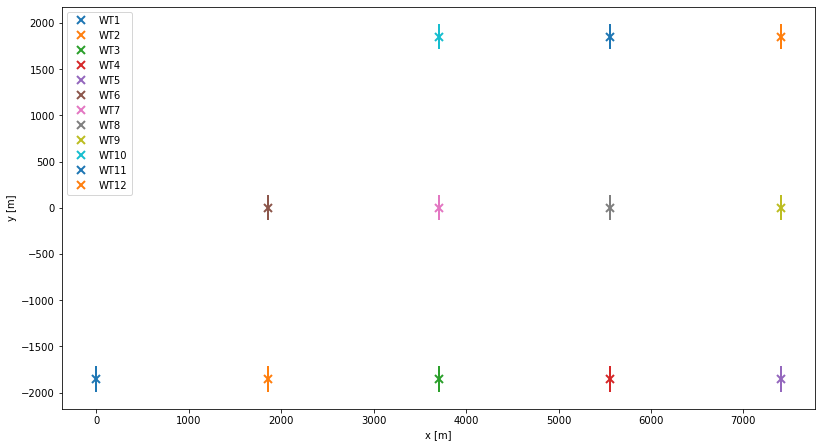

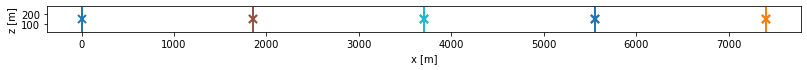

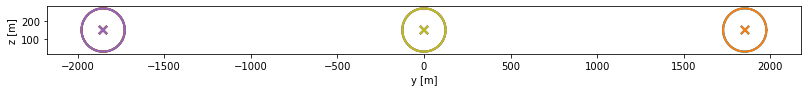

In [29]:
# Viz
fig = plotFastFarmSetup(outputFSTF, grid=True, D=D_, hubHeight=HubHt_, plane='XY')
fig = plotFastFarmSetup(outputFSTF, grid=True, D=D_, hubHeight=HubHt_, plane='XZ', showLegend=False)
fig = plotFastFarmSetup(outputFSTF, grid=True, D=D_, hubHeight=HubHt_, plane='YZ', showLegend=False)
plt.show()

In [298]:
# dX_low = round(Vmidlow.mean()*lowbts.dt)  # 10.6/0.3 = 3.17 = 3. Or, 8.6/0.3 = 2.58 = 3
# LX = 

# ff_file['DT_Low']     = lowbts.dt # change this. this is the same as the high box because we needed that for the time series to drive the high box
# ff_file['DT_High']    = highbts.dt
# ff_file['NX_Low']     = round(length/dx) + 1,  (length also multiple of dx)
# ff_file['NY_Low']     = lowbts.ny
# ff_file['NZ_Low']     = lowbts.nz
# ff_file['X0_Low']     = #int multiple of dx   -3*D multiple of dx
# ff_file['Y0_Low']     = lowbts.y[0]
# ff_file['Z0_Low']     = lowbts.z[0]
# ff_file['dX_Low']     = dX_low
# ff_file['dY_Low']     = np.diff(lowbts.y)[0]
# ff_file['dZ_Low']     = np.diff(lowbts.z)[0]
# ff_file['NX_High']    = # int multiple of dx high 0.55upstream of the turb then 0.55 downstream if extent_high is 1.1D
# ff_file['NY_High']    = highbts.ny
# ff_file['NZ_High']    = highbts.nz
# ff_file['InflowFile'] = "InflowWind.data"

### FAST.Farm: Prepare SLURM script and submit job

Two instances of FAST.Farm will be executed per 36-core node. It uses about 25GB RAM each.

In [15]:
# ----------------------------------------------
# ----- Prepare SLURM script for FAST.Farm -----
# ----------------------------------------------

status = os.system(f'cp {templatePath}/runAllFASTFarm.sh {path}/runAllFASTFarm.sh')

# Change job name (for convenience only)
_ = subprocess.call(f"sed -i 's|#SBATCH --job-name=runAllFF|#SBATCH --job-name=runAllFF_{os.path.basename(path)}|g' runAllFASTFarm.sh", cwd=path, shell=True)
# Change the path inside the script to the desired one
sed_command = f"sed -i 's|/projects/shellwind/rthedin/Task2_2regis|{path}|g' runAllFASTFarm.sh"
_ = subprocess.call(sed_command, cwd=path, shell=True)
# Change number of nodes values
nNodes = int(np.ceil((nConditions*nCases*nSeeds)))
_ = subprocess.call(f"sed -i 's|#SBATCH --nodes=3|#SBATCH --nodes={nNodes}|g' runAllFASTFarm.sh", cwd=path, shell=True)
# Assemble list of conditions and write it
listtoprint = "' '".join(condDirList)
sed_command = f"""sed -i "s|^condList.*|condList=('{listtoprint}')|g" runAllFASTFarm.sh"""
_ = subprocess.call(sed_command, cwd=path, shell=True)
# Assemble list of cases and write it
listtoprint = "' '".join(caseDirList)
sed_command = f"""sed -i "s|^caseList.*|caseList=('{listtoprint}')|g" runAllFASTFarm.sh"""
_ = subprocess.call(sed_command, cwd=path, shell=True)

In [ ]:
# ----------------------------------
# ---------- Run FAST.Farm ---------
# ----------------------------------
# Submit the script to SLURM
subprocess.call('sbatch runAllFASTFarm.sh', cwd=path)

---

# Post-processing

In [32]:
import matplotlib.patches as patches

In [35]:
vtkpath = '/projects/shellwind/rthedin/task_equinor_correctExtentHigh/Cond00_v08.6_PL0.2_TI10/Case00_wdirp00_WSfalse_YMfalse_12fED_12ADyn/Seed_0'

vtkpathlow_z150     = os.path.join(vtkpath, 'vtk_ff/FFarm_mod.Low.DisXY1.012.vtk')
vtkpathlow_y_t3     = os.path.join(vtkpath, 'vtk_ff/FFarm_mod.Low.DisYZ3.012.vtk')

vtkpathlow_x_toprow = os.path.join(vtkpath, 'vtk_ff/FFarm_mod.Low.DisXZ3.012.vtk')
vtkpathlow_x_midrow = os.path.join(vtkpath, 'vtk_ff/FFarm_mod.Low.DisXZ2.012.vtk')
vtkpathlow_x_botrow = os.path.join(vtkpath, 'vtk_ff/FFarm_mod.Low.DisXZ1.012.vtk')


# vtkpathhigh_t1      = '/projects/shellwind/rthedin/task_equinor_final/Cond00_v08.6_PL0.2_TI10/Case00_wdirp00_WSfalse_YMfalse/Seed_0/vtk_ff/FFarm_mod.HighT1.Dis.0300.vtk'
# vtkpathhigh_t2      = '/projects/shellwind/rthedin/task_equinor_final/Cond00_v08.6_PL0.2_TI10/Case00_wdirp00_WSfalse_YMfalse/Seed_0/vtk_ff/FFarm_mod.HighT2.Dis.0300.vtk'
# vtkpathhigh_t3      = '/projects/shellwind/rthedin/task_equinor_final/Cond00_v08.6_PL0.2_TI10/Case00_wdirp00_WSfalse_YMfalse/Seed_0/vtk_ff/FFarm_mod.HighT3.Dis.0300.vtk'
# vtkpathhigh_t6      = '/projects/shellwind/rthedin/task_equinor_final/Cond00_v08.6_PL0.2_TI10/Case00_wdirp00_WSfalse_YMfalse/Seed_0/vtk_ff/FFarm_mod.HighT6.Dis.0300.vtk'



In [36]:
vtklow_z150 = VTKFile(vtkpathlow_z150)
vtklow_y_t3 = VTKFile(vtkpathlow_y_t3)
vtklow_x_toprow = VTKFile(vtkpathlow_x_toprow)
vtklow_x_midrow = VTKFile(vtkpathlow_x_midrow)
vtklow_x_botrow = VTKFile(vtkpathlow_x_botrow)

# vtkhigh_t1 = VTKFile(vtkpathhigh_t1)
# vtkhigh_t2 = VTKFile(vtkpathhigh_t2)
# vtkhigh_t3 = VTKFile(vtkpathhigh_t3)
# vtkhigh_t6 = VTKFile(vtkpathhigh_t6)

In [37]:
ulow_z150 = vtklow_z150.point_data_grid['Velocity'][:,:,:,0]
vlow_z150 = vtklow_z150.point_data_grid['Velocity'][:,:,:,1]
wlow_z150 = vtklow_z150.point_data_grid['Velocity'][:,:,:,2]

ulow_y_t3 = vtklow_y_t3.point_data_grid['Velocity'][:,:,:,0]
vlow_y_t3 = vtklow_y_t3.point_data_grid['Velocity'][:,:,:,1]
wlow_y_t3 = vtklow_y_t3.point_data_grid['Velocity'][:,:,:,2]

ulow_x_toprow = vtklow_x_toprow.point_data_grid['Velocity'][:,:,:,0]
vlow_x_toprow = vtklow_x_toprow.point_data_grid['Velocity'][:,:,:,1]
wlow_x_toprow = vtklow_x_toprow.point_data_grid['Velocity'][:,:,:,2]

ulow_x_midrow = vtklow_x_midrow.point_data_grid['Velocity'][:,:,:,0]
vlow_x_midrow = vtklow_x_midrow.point_data_grid['Velocity'][:,:,:,1]
wlow_x_midrow = vtklow_x_midrow.point_data_grid['Velocity'][:,:,:,2]

ulow_x_botrow = vtklow_x_botrow.point_data_grid['Velocity'][:,:,:,0]
vlow_x_botrow = vtklow_x_botrow.point_data_grid['Velocity'][:,:,:,1]
wlow_x_botrow = vtklow_x_botrow.point_data_grid['Velocity'][:,:,:,2]

# uhigh_t1 = vtkhigh_t1.point_data_grid['Velocity'][:,:,:,0]
# vhigh_t1 = vtkhigh_t1.point_data_grid['Velocity'][:,:,:,1]
# whigh_t2 = vtkhigh_t1.point_data_grid['Velocity'][:,:,:,2]
# uhigh_t2 = vtkhigh_t2.point_data_grid['Velocity'][:,:,:,0]
# vhigh_t2 = vtkhigh_t2.point_data_grid['Velocity'][:,:,:,1]
# whigh_t1 = vtkhigh_t2.point_data_grid['Velocity'][:,:,:,2]
# uhigh_t3 = vtkhigh_t3.point_data_grid['Velocity'][:,:,:,0]
# vhigh_t3 = vtkhigh_t3.point_data_grid['Velocity'][:,:,:,1]
# whigh_t3 = vtkhigh_t3.point_data_grid['Velocity'][:,:,:,2]
# uhigh_t6 = vtkhigh_t6.point_data_grid['Velocity'][:,:,:,0]
# vhigh_t6 = vtkhigh_t6.point_data_grid['Velocity'][:,:,:,1]
# whigh_t6 = vtkhigh_t6.point_data_grid['Velocity'][:,:,:,2]

In [38]:
X0_High_T1 = vtkhigh_t1.xp_grid[0]
Y0_High_T1 = vtkhigh_t1.yp_grid[0]
Z0_High_T1 = vtkhigh_t1.zp_grid[0]
LX_High_T1 = (vtkhigh_t1.xp_grid[-1]-vtkhigh_t1.xp_grid[0])
LY_High_T1 = (vtkhigh_t1.yp_grid[-1]-vtkhigh_t1.yp_grid[0])
LZ_High_T1 = (vtkhigh_t1.zp_grid[-1]-vtkhigh_t1.zp_grid[0])

X0_High_T2 = vtkhigh_t2.xp_grid[0]
Y0_High_T2 = vtkhigh_t2.yp_grid[0]
Z0_High_T2 = vtkhigh_t2.zp_grid[0]
LX_High_T2 = (vtkhigh_t2.xp_grid[-1]-vtkhigh_t2.xp_grid[0])
LY_High_T2 = (vtkhigh_t2.yp_grid[-1]-vtkhigh_t2.yp_grid[0])
LZ_High_T2 = (vtkhigh_t2.zp_grid[-1]-vtkhigh_t2.zp_grid[0])

X0_High_T3 = vtkhigh_t3.xp_grid[0]
Y0_High_T3 = vtkhigh_t3.yp_grid[0]
Z0_High_T3 = vtkhigh_t3.zp_grid[0]
LX_High_T3 = (vtkhigh_t3.xp_grid[-1]-vtkhigh_t3.xp_grid[0])
LY_High_T3 = (vtkhigh_t3.yp_grid[-1]-vtkhigh_t3.yp_grid[0])
LZ_High_T3 = (vtkhigh_t3.zp_grid[-1]-vtkhigh_t3.zp_grid[0])

X0_High_T6 = vtkhigh_t6.xp_grid[0]
Y0_High_T6 = vtkhigh_t6.yp_grid[0]
Z0_High_T6 = vtkhigh_t6.zp_grid[0]
LX_High_T6 = (vtkhigh_t6.xp_grid[-1]-vtkhigh_t6.xp_grid[0])
LY_High_T6 = (vtkhigh_t6.yp_grid[-1]-vtkhigh_t6.yp_grid[0])
LZ_High_T6 = (vtkhigh_t6.zp_grid[-1]-vtkhigh_t6.zp_grid[0])

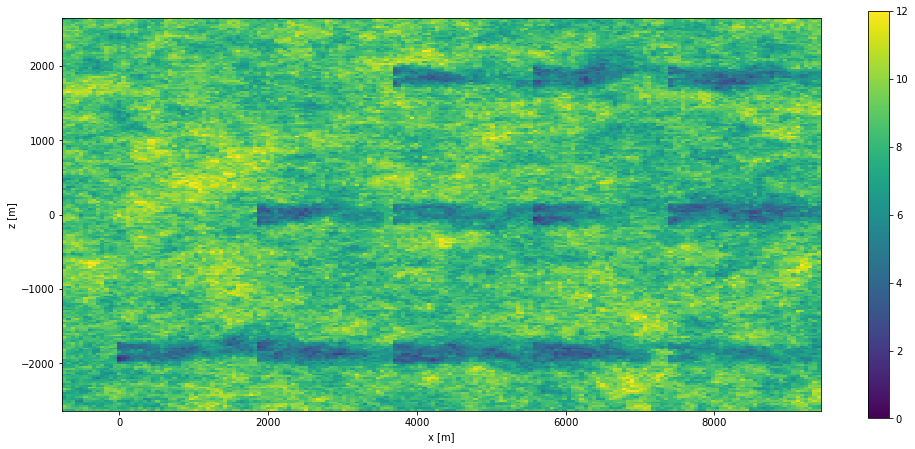

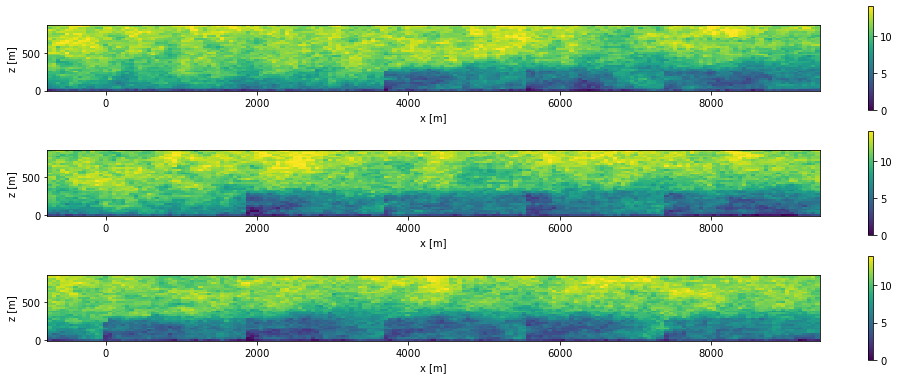

In [38]:
vmin=0 
vmax=12

fig,ax = plt.subplots(figsize=(17,7.5))
im=ax.contourf(  vtklow_z150.xp_grid, vtklow_z150.yp_grid, ulow_z150[:,:,0].T, vmin=vmin, vmax=vmax)
im=ax.pcolormesh(vtklow_z150.xp_grid, vtklow_z150.yp_grid, ulow_z150[:,:,0].T, vmin=vmin, vmax=vmax)
fig.colorbar(im)

# ax.add_patch(patches.Rectangle((X0_High_T1, Y0_High_T1), LX_High_T1, LY_High_T1, linewidth=1, edgecolor='r', facecolor='none'))
# ax.add_patch(patches.Rectangle((X0_High_T2, Y0_High_T2), LX_High_T2, LY_High_T2, linewidth=1, edgecolor='m', facecolor='none'))
# ax.add_patch(patches.Rectangle((X0_High_T3, Y0_High_T3), LX_High_T3, LY_High_T3, linewidth=1, edgecolor='b', facecolor='none'))
# ax.add_patch(patches.Rectangle((X0_High_T6, Y0_High_T6), LX_High_T6, LY_High_T6, linewidth=1, edgecolor='w', facecolor='none'))

ax.set_xlabel('x [m]')
ax.set_ylabel('z [m]')
ax.set_aspect('equal')
plt.show()



vmin=0 
vmax=14

fig,axs = plt.subplots(nrows=3, figsize=(17.3,6.5))

im=axs[0].contourf(  vtklow_x_toprow.xp_grid, vtklow_x_toprow.zp_grid, ulow_x_toprow[:,0,:].T, vmin=vmin, vmax=vmax)
im=axs[0].pcolormesh(vtklow_x_toprow.xp_grid, vtklow_x_toprow.zp_grid, ulow_x_toprow[:,0,:].T, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axs[0])

im=axs[1].contourf(  vtklow_x_midrow.xp_grid, vtklow_x_midrow.zp_grid, ulow_x_midrow[:,0,:].T, vmin=vmin, vmax=vmax)
im=axs[1].pcolormesh(vtklow_x_midrow.xp_grid, vtklow_x_midrow.zp_grid, ulow_x_midrow[:,0,:].T, vmin=vmin, vmax=vmax)
# axs[1].add_patch(patches.Rectangle((X0_High_T6, Z0_High_T6), LX_High_T6, LZ_High_T6, linewidth=1, edgecolor='w', facecolor='none'))
fig.colorbar(im, ax=axs[1])

im=axs[2].contourf(  vtklow_x_botrow.xp_grid, vtklow_x_botrow.zp_grid, ulow_x_botrow[:,0,:].T, vmin=vmin, vmax=vmax)
im=axs[2].pcolormesh(vtklow_x_botrow.xp_grid, vtklow_x_botrow.zp_grid, ulow_x_botrow[:,0,:].T, vmin=vmin, vmax=vmax)
# axs[2].add_patch(patches.Rectangle((X0_High_T1, Z0_High_T1), LX_High_T1, LZ_High_T1, linewidth=1, edgecolor='r', facecolor='none'))
# axs[2].add_patch(patches.Rectangle((X0_High_T2, Z0_High_T2), LX_High_T2, LZ_High_T2, linewidth=1, edgecolor='m', facecolor='none'))
# axs[2].add_patch(patches.Rectangle((X0_High_T3, Z0_High_T3), LX_High_T3, LZ_High_T3, linewidth=1, edgecolor='b', facecolor='none'))
fig.colorbar(im, ax=axs[2])


for ax in axs:
    ax.set_xlabel('x [m]')
    ax.set_ylabel('z [m]')
    ax.set_aspect('equal')
plt.show()

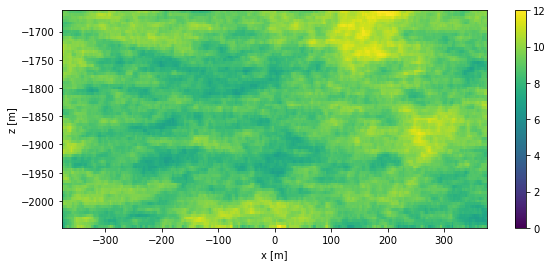

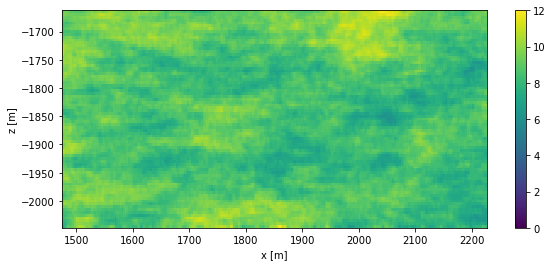

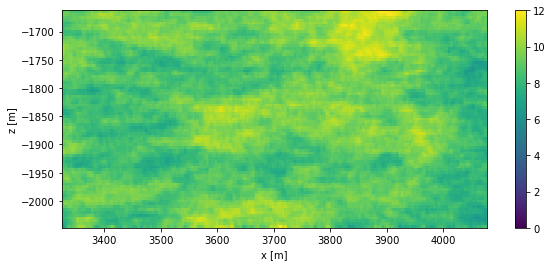

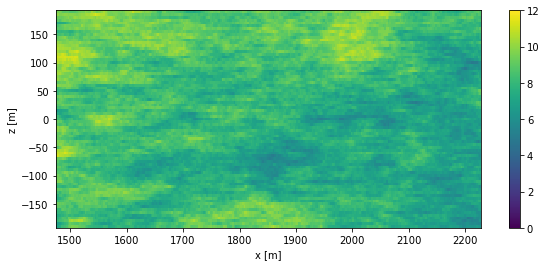

In [40]:
vmin=0 
vmax=12

fig,ax = plt.subplots(figsize=(10,4))
im=ax.contourf(  vtkhigh_t1.xp_grid, vtkhigh_t1.yp_grid, uhigh_t1[:,:,30].T, vmin=vmin, vmax=vmax)
im=ax.pcolormesh(vtkhigh_t1.xp_grid, vtkhigh_t1.yp_grid, uhigh_t1[:,:,30].T, vmin=vmin, vmax=vmax)
fig.colorbar(im)
ax.set_xlabel('x [m]')
ax.set_ylabel('z [m]')
ax.set_aspect('equal')
plt.show()

fig,ax = plt.subplots(figsize=(10,4))
im=ax.contourf(  vtkhigh_t2.xp_grid, vtkhigh_t2.yp_grid, uhigh_t2[:,:,30].T, vmin=vmin, vmax=vmax)
im=ax.pcolormesh(vtkhigh_t2.xp_grid, vtkhigh_t2.yp_grid, uhigh_t2[:,:,30].T, vmin=vmin, vmax=vmax)
fig.colorbar(im)
ax.set_xlabel('x [m]')
ax.set_ylabel('z [m]')
ax.set_aspect('equal')
plt.show()

fig,ax = plt.subplots(figsize=(10,4))
im=ax.contourf(  vtkhigh_t3.xp_grid, vtkhigh_t3.yp_grid, uhigh_t3[:,:,30].T, vmin=vmin, vmax=vmax)
im=ax.pcolormesh(vtkhigh_t3.xp_grid, vtkhigh_t3.yp_grid, uhigh_t3[:,:,30].T, vmin=vmin, vmax=vmax)
fig.colorbar(im)
ax.set_xlabel('x [m]')
ax.set_ylabel('z [m]')
ax.set_aspect('equal')
plt.show()

fig,ax = plt.subplots(figsize=(10,4))
im=ax.contourf(  vtkhigh_t6.xp_grid, vtkhigh_t6.yp_grid, uhigh_t6[:,:,30].T, vmin=vmin, vmax=vmax)
im=ax.pcolormesh(vtkhigh_t6.xp_grid, vtkhigh_t6.yp_grid, uhigh_t6[:,:,30].T, vmin=vmin, vmax=vmax)
fig.colorbar(im)
ax.set_xlabel('x [m]')
ax.set_ylabel('z [m]')
ax.set_aspect('equal')
plt.show()

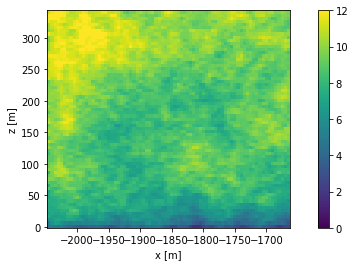

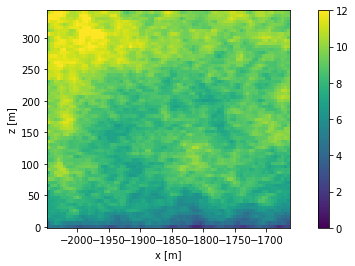

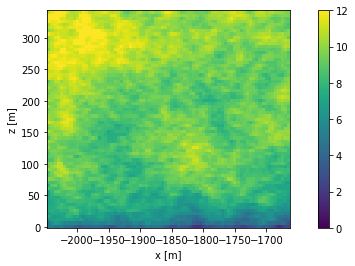

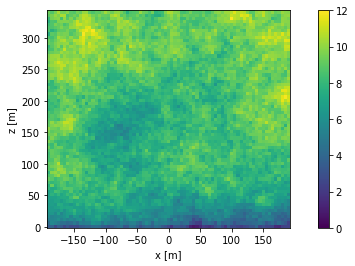

In [41]:
vmin=0 
vmax=12

fig,ax = plt.subplots(figsize=(10,4))
im=ax.contourf(  vtkhigh_t1.yp_grid, vtkhigh_t1.zp_grid, uhigh_t1[125,:,:].T, vmin=vmin, vmax=vmax)
im=ax.pcolormesh(vtkhigh_t1.yp_grid, vtkhigh_t1.zp_grid, uhigh_t1[125,:,:].T, vmin=vmin, vmax=vmax)
fig.colorbar(im)
ax.set_xlabel('x [m]')
ax.set_ylabel('z [m]')
ax.set_aspect('equal')
plt.show()

fig,ax = plt.subplots(figsize=(10,4))
im=ax.contourf(  vtkhigh_t2.yp_grid, vtkhigh_t2.zp_grid, uhigh_t2[125,:,:].T, vmin=vmin, vmax=vmax)
im=ax.pcolormesh(vtkhigh_t2.yp_grid, vtkhigh_t2.zp_grid, uhigh_t2[125,:,:].T, vmin=vmin, vmax=vmax)
fig.colorbar(im)
ax.set_xlabel('x [m]')
ax.set_ylabel('z [m]')
ax.set_aspect('equal')
plt.show()

fig,ax = plt.subplots(figsize=(10,4))
im=ax.contourf(  vtkhigh_t3.yp_grid, vtkhigh_t3.zp_grid, uhigh_t3[125,:,:].T, vmin=vmin, vmax=vmax)
im=ax.pcolormesh(vtkhigh_t3.yp_grid, vtkhigh_t3.zp_grid, uhigh_t3[125,:,:].T, vmin=vmin, vmax=vmax)
fig.colorbar(im)
ax.set_xlabel('x [m]')
ax.set_ylabel('z [m]')
ax.set_aspect('equal')
plt.show()

fig,ax = plt.subplots(figsize=(10,4))
im=ax.contourf(  vtkhigh_t6.yp_grid, vtkhigh_t6.zp_grid, uhigh_t6[125,:,:].T, vmin=vmin, vmax=vmax)
im=ax.pcolormesh(vtkhigh_t6.yp_grid, vtkhigh_t6.zp_grid, uhigh_t6[125,:,:].T, vmin=vmin, vmax=vmax)
fig.colorbar(im)
ax.set_xlabel('x [m]')
ax.set_ylabel('z [m]')
ax.set_aspect('equal')
plt.show()

### turbines

In [ ]:
## my DX_Low is a lot larger than before (coaser figure above)
   ## seems okay
    
## what dt on the fst input files should I have? currently 0.005 s
## warning of wake leaving domain and leaving high-res. 
## compelast is not taking the 3 options (SED)

In [39]:
from pyFAST.input_output import FASTOutputFile

In [76]:

df_t1  = FASTOutputFile(os.path.join(path,'Cond00_v08.6_PL0.2_TI10/Case00_wdirp00_WSfalse_YMfalse_12fED_12ADyn/Seed_0','FFarm_mod.T1.out' )).toDataFrame()
df_t2  = FASTOutputFile(os.path.join(path,'Cond00_v08.6_PL0.2_TI10/Case00_wdirp00_WSfalse_YMfalse_12fED_12ADyn/Seed_0','FFarm_mod.T2.out' )).toDataFrame()
df_t3  = FASTOutputFile(os.path.join(path,'Cond00_v08.6_PL0.2_TI10/Case00_wdirp00_WSfalse_YMfalse_12fED_12ADyn/Seed_0','FFarm_mod.T3.out' )).toDataFrame()
df_t4  = FASTOutputFile(os.path.join(path,'Cond00_v08.6_PL0.2_TI10/Case00_wdirp00_WSfalse_YMfalse_12fED_12ADyn/Seed_0','FFarm_mod.T4.out' )).toDataFrame()
df_t5  = FASTOutputFile(os.path.join(path,'Cond00_v08.6_PL0.2_TI10/Case00_wdirp00_WSfalse_YMfalse_12fED_12ADyn/Seed_0','FFarm_mod.T5.out' )).toDataFrame()
df_t6  = FASTOutputFile(os.path.join(path,'Cond00_v08.6_PL0.2_TI10/Case00_wdirp00_WSfalse_YMfalse_12fED_12ADyn/Seed_0','FFarm_mod.T6.out' )).toDataFrame()
df_t7  = FASTOutputFile(os.path.join(path,'Cond00_v08.6_PL0.2_TI10/Case00_wdirp00_WSfalse_YMfalse_12fED_12ADyn/Seed_0','FFarm_mod.T7.out' )).toDataFrame()
df_t8  = FASTOutputFile(os.path.join(path,'Cond00_v08.6_PL0.2_TI10/Case00_wdirp00_WSfalse_YMfalse_12fED_12ADyn/Seed_0','FFarm_mod.T8.out' )).toDataFrame()
df_t9  = FASTOutputFile(os.path.join(path,'Cond00_v08.6_PL0.2_TI10/Case00_wdirp00_WSfalse_YMfalse_12fED_12ADyn/Seed_0','FFarm_mod.T9.out' )).toDataFrame()
df_t10 = FASTOutputFile(os.path.join(path,'Cond00_v08.6_PL0.2_TI10/Case00_wdirp00_WSfalse_YMfalse_12fED_12ADyn/Seed_0','FFarm_mod.T10.out')).toDataFrame()
df_t11 = FASTOutputFile(os.path.join(path,'Cond00_v08.6_PL0.2_TI10/Case00_wdirp00_WSfalse_YMfalse_12fED_12ADyn/Seed_0','FFarm_mod.T11.out')).toDataFrame()
df_t12 = FASTOutputFile(os.path.join(path,'Cond00_v08.6_PL0.2_TI10/Case00_wdirp00_WSfalse_YMfalse_12fED_12ADyn/Seed_0','FFarm_mod.T12.out')).toDataFrame()


In [51]:
print([df_t1.columns[i] for i in range(len(df_t1.columns))])

['Time_[s]', 'Wind1VelX_[m/s]', 'Wind1VelY_[m/s]', 'Wind1VelZ_[m/s]', 'Azimuth_[deg]', 'BldPitch1_[deg]', 'GenSpeed_[rpm]', 'IPDefl1_[m]', 'OoPDefl1_[m]', 'LSSGagMya_[kN-m]', 'LSSGagMza_[kN-m]', 'PtfmPitch_[deg]', 'PtfmRoll_[deg]', 'PtfmSurge_[m]', 'PtfmSway_[m]', 'RootMIP1_[kN-m]', 'RootMOoP1_[kN-m]', 'RootMzc1_[kN-m]', 'RotSpeed_[rpm]', 'RotTorq_[kN-m]', 'RotThrust_[kN]', 'RotPwr_[kW]', 'YawBrMxp_[kN-m]', 'YawBrMyp_[kN-m]', 'YawBrMzp_[kN-m]', 'TwrBsMxt_[kN-m]', 'TwrBsMyt_[kN-m]', 'TwrBsMzt_[kN-m]', 'TTDspFA_[m]', 'TTDspSS_[m]', 'YawPzn_[deg]', 'TipClrnc1_[m]', 'RtAeroFxh_[N]', 'RtAeroFyh_[N]', 'RtAeroFzh_[N]', 'RtAeroMxh_[N-m]', 'RtAeroMyh_[N-m]', 'RtAeroMzh_[N-m]', 'RtVAvgxh_[m/s]', 'RtAeroCp_[-]', 'RtAeroCt_[-]', 'RtArea_[m^2]', 'RtSpeed_[rpm]', 'RtTSR_[-]', 'AB1N001Vrel_[m/s]', 'AB1N002Vrel_[m/s]', 'AB1N003Vrel_[m/s]', 'AB1N004Vrel_[m/s]', 'AB1N005Vrel_[m/s]', 'AB1N006Vrel_[m/s]', 'AB1N007Vrel_[m/s]', 'AB1N008Vrel_[m/s]', 'AB1N009Vrel_[m/s]', 'AB1N010Vrel_[m/s]', 'AB1N011Vrel_[m/s

In [81]:
time_t1  = df_t1['Time_[s]'];   omega_t1  = df_t1['RotSpeed_[rpm]'];   velx_t1   = df_t1['Wind1VelX_[m/s]'];   power_t1  = df_t1['RotPwr_[kW]']
time_t2  = df_t2['Time_[s]'];   omega_t2  = df_t2['RotSpeed_[rpm]'];   velx_t2   = df_t2['Wind1VelX_[m/s]'];   power_t2  = df_t2['RotPwr_[kW]']
time_t3  = df_t3['Time_[s]'];   omega_t3  = df_t3['RotSpeed_[rpm]'];   velx_t3   = df_t3['Wind1VelX_[m/s]'];   power_t3  = df_t3['RotPwr_[kW]']
time_t4  = df_t4['Time_[s]'];   omega_t4  = df_t4['RotSpeed_[rpm]'];   velx_t4   = df_t4['Wind1VelX_[m/s]'];   power_t4  = df_t4['RotPwr_[kW]']
time_t5  = df_t5['Time_[s]'];   omega_t5  = df_t5['RotSpeed_[rpm]'];   velx_t5   = df_t5['Wind1VelX_[m/s]'];   power_t5  = df_t5['RotPwr_[kW]']
time_t6  = df_t6['Time_[s]'];   omega_t6  = df_t6['RotSpeed_[rpm]'];   velx_t6   = df_t6['Wind1VelX_[m/s]'];   power_t6  = df_t6['RotPwr_[kW]']
time_t7  = df_t7['Time_[s]'];   omega_t7  = df_t7['RotSpeed_[rpm]'];   velx_t7   = df_t7['Wind1VelX_[m/s]'];   power_t7  = df_t7['RotPwr_[kW]']
time_t8  = df_t8['Time_[s]'];   omega_t8  = df_t8['RotSpeed_[rpm]'];   velx_t8   = df_t8['Wind1VelX_[m/s]'];   power_t8  = df_t8['RotPwr_[kW]']
time_t9  = df_t9['Time_[s]'];   omega_t9  = df_t9['RotSpeed_[rpm]'];   velx_t9   = df_t9['Wind1VelX_[m/s]'];   power_t9  = df_t9['RotPwr_[kW]']
time_t10 = df_t10['Time_[s]'];  omega_t10 = df_t10['RotSpeed_[rpm]'];  velx_t10  = df_t10['Wind1VelX_[m/s]'];  power_t10 = df_t10['RotPwr_[kW]']
time_t11 = df_t11['Time_[s]'];  omega_t11 = df_t11['RotSpeed_[rpm]'];  velx_t11  = df_t11['Wind1VelX_[m/s]'];  power_t11 = df_t11['RotPwr_[kW]']
time_t12 = df_t12['Time_[s]'];  omega_t12 = df_t12['RotSpeed_[rpm]'];  velx_t12  = df_t12['Wind1VelX_[m/s]'];  power_t12 = df_t12['RotPwr_[kW]']


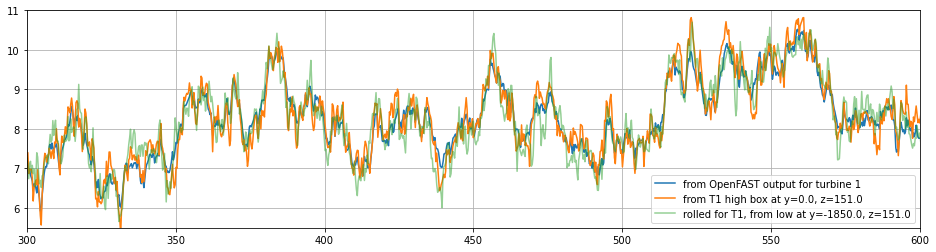

In [61]:
fig, ax = plt.subplots(figsize=(16,4))

ax.plot(time, velx,                                                   label=f"from OpenFAST output for turbine {turb}")
ax.plot(highinflow['t'], highinflow['u'][0,:,jTurb_high, kTurb_high], label=f"from T{turb} high box at y={highinflow['y'][jTurb_high]}, z={highinflow['z'][kTurb_high]}")
ax.plot(lowinflow['t'], uvel,                                         label=f"rolled for T{turb}, from low at y={lowinflow['y'][jTurb_low]}, z={lowinflow['z'][kTurb_low]}", alpha=0.5)

ax.set_xlim([300,600])
ax.set_ylim([5.5,11])
ax.grid()
ax.legend()


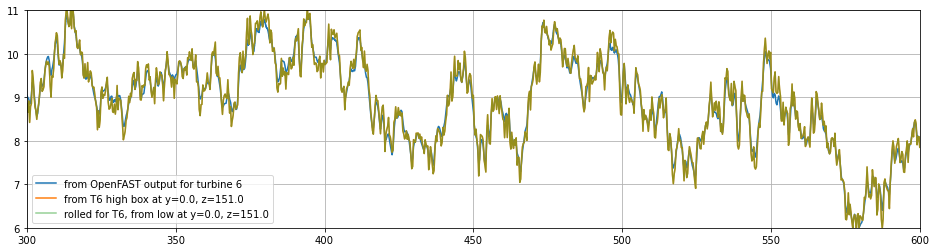

In [70]:
fig, ax = plt.subplots(figsize=(16,4))

ax.plot(time_t6, velx_t6,                                                   label=f"from OpenFAST output for turbine {turb}")
ax.plot(highinflow['t'], highinflow['u'][0,:,jTurb_high, kTurb_high], label=f"from T{turb} high box at y={highinflow['y'][jTurb_high]}, z={highinflow['z'][kTurb_high]}")
ax.plot(lowinflow['t'], uvel,                                         label=f"rolled for T{turb}, from low at y={lowinflow['y'][jTurb_low]}, z={lowinflow['z'][kTurb_low]}", alpha=0.5)

ax.set_xlim([300,600])
ax.set_ylim([6,11])
ax.grid()
ax.legend()
plt.show()

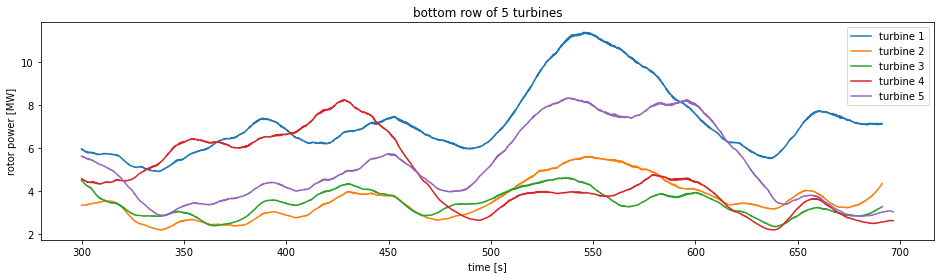

In [86]:
fig, ax = plt.subplots(figsize=(16,4))

ax.plot(time_t1, power_t1/1e3, label='turbine 1')
ax.plot(time_t2, power_t2/1e3, label='turbine 2')
ax.plot(time_t3, power_t3/1e3, label='turbine 3')
ax.plot(time_t4, power_t4/1e3, label='turbine 4')
ax.plot(time_t5, power_t5/1e3, label='turbine 5')

ax.set_title('bottom row of 5 turbines')
#ax.set_xlim([300,600])
ax.set_xlabel('time [s]')
ax.set_ylabel('rotor power [MW]')
ax.legend()
plt.show()


In [ ]:
# 1850m between each turbine. at 8.6 m/s mean wspd, that is about 215s

In [87]:
meanpower_t1  = power_t1.mean()
meanpower_t2  = power_t2.mean()
meanpower_t3  = power_t3.mean()
meanpower_t4  = power_t4.mean()
meanpower_t5  = power_t5.mean()
meanpower_t6  = power_t6.mean()
meanpower_t7  = power_t7.mean()
meanpower_t8  = power_t8.mean()
meanpower_t9  = power_t9.mean()
meanpower_t10 = power_t10.mean()
meanpower_t11 = power_t11.mean()
meanpower_t12 = power_t12.mean()


In [ ]:
botrow = [meanpower_t1/meanpower_t1,   meanpower_t2/meanpower_t1,  meanpower_t3/meanpower_t1,   meanpower_t4/meanpower_t1,   meanpower_t5/meanpower_t1]
midrow = [meanpower_t6/meanpower_t6,   meanpower_t7/meanpower_t6,  meanpower_t8/meanpower_t6,   meanpower_t9/meanpower_t6]
toprow = [meanpower_t10/meanpower_t10, meanpower_t11/meanpower_t10, meanpower_t12/meanpower_t10]

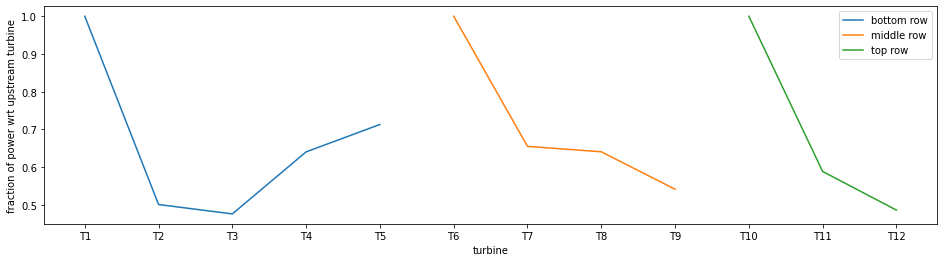

In [91]:
fig, ax = plt.subplots(figsize=(16,4))


ax.plot(['T1', 'T2', 'T3', 'T4', 'T5'], botrow, label='bottom row')


ax.plot(['T6', 'T7', 'T8', 'T9'], midrow, label='middle row')


ax.plot(['T10', 'T11', 'T12'], toprow, label='top row')


ax.set_xlabel('turbine')
ax.set_ylabel('fraction of power wrt upstream turbine')
ax.legend()
plt.show()


# Notes

## Regis note

This was copied from Kelsey's files, notebook with the same name. The original files are in ~/fromOther/fromKelsey. Copying here to play with it.

July 25 2022


From Kelsey:
If doing turbsim, all i need is to run this, modifying just a couple of things. If SOWFA, I don't need a lot of things from here. Here is sets a bunch of parameters. Since I'm doing a bunch of inflow angles, it might be useful for me.


### Nomenclature
"inflow" : diff atmospheric conditions, which varies with diff wspd, TI, shear combinations. She had 5 vhub (6.6, 8.6, 10.6, 12.6, 16.6m/s), 3 shears (0.1, 0.2, 0.3), 3 TI (B, C, D), which is $5*3*3 = 45$ inflows. Indeed, her dirs go from Inflow00 to Inflow44

"case"   : diff inflow angles. She had-20 to 20 in 2 steps, so 21 different angles. She does have wake steering on/off and yaw misalignment on/off. Thus $21*2*2 = 84$ cases. Her dirs, within each Inflow go from Case_0 to Case_83

"seed"   : this is a turbsim thing. the seed seems to be related to the randomness. IEC recommends 6 seeds. it's known not to be enough, but oh well, they use 6. K has used 

In here, there are 45 inflow conditions (see variable `ParamVals` with 45 columns), times 42 inflow directions ("cases") times 2 (with and without wake steering). so that is why she has all these loops. With and without wake steering are lumped into "cases" (i.e., 84 total cases). In summary, 45 "inflow" (conditions), on 84 "cases" (inflow angles). Remember, 6 seeds for each TurbSim.

Her file structure in `/projects/shellwind/kshaler/Task2_2` is


## Flow

Flow of operations


- Now we have `NewParams_Shell.csv`, `BinVals.csv`, `NewFFParams_Shell.csv`, on `kshaler/Shell/`
- Use `NewParams_Shell.csv`, `BinVals.csv`, and `NewFFParams_Shell.csv` as input to  `CaseCreation_FFarm_Shell_Inflow*.py`. The last thing on the script is the call to `ParameterManipulation.createFFParamFiles`, which created `Inflow*/Case_*/Seed_*/FFarmParams.txt` for all seeds of all cases within a certain Inflow.
- The `CaseCreation_FFarm_Shell_Inflow*.py` is called from within a SLURM job, `SubFile_Inflow00to05.sh` (with the appropriate numbering). The notebook `CaseCreate_FFarm_Shell_WakeSteer.ipynb` is pretty much this `.py` script in notebook form.
- Now we supposedly have `Task2_2/Inflow*/Case_*/Seed_*/FFarm_Params.txt`, inflow varying from from 00 to 44, Case 0 to 83, Seed 0 to 5.
- The scripts `CaseCreation_FFarm_Shell_Inflow*to*.py` are different (misleading name).
    - They have `writeTimeSeriesFile`


- `PostProcessing/CaseSetup/Inputsetup.py` has the function `FFInputCreation` that uses the `FFarmParams.txt` and it _seems_ like it outputs `_mod.fstf` file based on the `.fstf` 





- `CaseCreation_FFarm_Shell_Inflow*.py`:
    - Reads `NewParams_Shell.csv` (contains 45 columns of "Inflows", that is, combination of shear/TI/vhub/turbLocation)
    - Creates array of case names `caseNames = ['Inflow00', ... 'Inflow44']` and use that to rename the index of `ParamVals`
    - Reads `BinVals.csv` (contains 5 different combinations of WaveHs, WaveTp, RotSpeed, and BlPitch)
    - Reads `NewFFParams_Shell.csv` (contains 93 coluns of combinations of windDir/Misalignement/WakeSteer. The last two are bools.)
      - Goes into a variable called `Yaw`
    - Sets `nCases` as 93 based on the `Yaw` variable above. 
      - NOTE: the last 9 coluns are NaN, which means the file NEWFFParams_Shell and the `Yaw` var only have 84 columns.
      - nCases is still set to 93 for me, but it seems like she would have fixed this.
    - Overwrite `caseNames` to be `['Case_0', ..., 'Case_92']` (maybe hers went up to 84.), use that to rename index of `Yaw`
    - Her `binVals` is probably related to turbulence class from the standard. each wspd (6.6, 8.6, 10.6, 12.6) receives one combination
    - changes into the directory "Inflow*" and creates `FFarmParams.txt`.
    
    
- This is what `FFarmParams.txt` looks like (I aligned things):
```
D   246.0
HubHt   148.84
high_extent_X   1.2
high_extent_Y   1.2
xlocs   0.000   1780.257  3560.513  5340.770  7121.027   2290.737   4070.994   5851.250   7631.507   4581.474   6361.731   8141.987
ylocs   0.000   510.480   1020.961  1531.441  2041.922  -1269.776  -759.296   -248.816    261.665   -2539.553  -2029.072  -1518.592
zlocs   0.000   0.000     0.000     0.000     0.000      0.000      0.000      0.000      0.000      0.000      0.000      0.000
  ```
  
  
  
----
- I need to first run the Low box
- Get time series at the turbine locations from the Low box
- Create High boxes giving the timeseries and selecting `"TIMESR"` as `TurbModel`